# OC PROJET 7 - Developper une preuve de concept
<br></br>
<div id="toc"></div>

Ce projet à pour but d'améliorer les performances du projet de classification automatique des races de chiens<br> 
en se basant sur le dataset d'images de Stanford Dogs Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/).

Divers module State-Of-The-Art vont être testé et comparé tel que Lion, CoaT, ViT,<br> 
nous allons voir chaque module un par un et enfin faire des benchmarks comparatifs pour conclure.


### SOMMAIRE
- <a href="#C1">I. Setup</a>
    - <a href="#C11">1. Installation</a>
    - <a href="#C12">2. Fonctions Principales</a>
<br></br>   
    
- <a href="#C2">II. Tests</a>
     - 1. <a href="#C21">Lion</a>
     - 2. <a href="#C22">CoaT</a>
     - 3. <a href="#C23">ViT</a>
<br></br> 
     
- <a href="#C3">III. Benchmark</a>
     
<br></br>      


# <a name="C1">1. Setup</a>

## <a name="C11">1.1 Installation</a>

In [ ]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [1]:
# general modules
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Image

# pytorch modules
import torch
import torchvision
import torch.nn as nn
from torch import nn, optim
from torch.optim import Adam
from lion_pytorch import Lion
from torch.nn import Transformer
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader

# scikit-learn modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [36]:
#GPU check
print(torch.cuda.is_available())

True


In [37]:
# Vérifier si le GPU est disponible et l'attribuer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# Chemin vers le dossier contenant les images
data_dir = "Images"

## <a name="C12">1.2 Fonctions Principales</a>

### Entrainement du modèle

In [39]:
# Fonction pour l'entrainement et la validation
def train_and_validate(model, criterion, optimizer, epochs=20):
    history = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        # chaque epoque a sa phase de train et validation
        for phase in ['train', 'val']:
            if phase == 'train':
                # on entraine le modèle
                model.train()  
                dataloader = train_loader
            else:
                # on évalue le modèle
                model.eval()   
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Initialisation de la barre de progrès
            pbar = tqdm(dataloader)

            # Intération sur les données
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Paramètre zero gradient
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # De https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimise uniquement en phase de training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistiques
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update de la barre de progrès
                pbar.set_description(f'{phase} Loss: {running_loss:.4f} {phase} Acc: {running_corrects.double()/len(dataloader.dataset):.4f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

            history.append({'epoch': epoch+1, 'phase': phase, 'loss': epoch_loss, 'acc': epoch_acc})

    return model, history

### Evaluation du modèle

In [40]:
def evaluate_model(model, val_loader, class_names, device):
    """
    Évalue le modèle de classification d'image sur le jeu de validation.

    Args:
    model : Le modèle entraîné.
    val_loader : DataLoader pour les données de validation.
    class_names : Noms des classes.
    device : Dispositif sur lequel exécuter le modèle (par exemple, 'cpu' ou 'cuda').

    Returns:
    Un rapport de classification pour le modèle sur le jeu de validation.
    """
    # Mettre le modèle en mode d'évaluation
    model.eval()

    all_labels = []
    all_preds = []

    # Itérer sur toutes les données de validation
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Calculer les prédictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Ajouter les labels et les prédictions à leurs listes respectives
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculer et retourner le rapport de classification
    return classification_report(all_labels, all_preds, target_names=class_names)

### Transformations, Data Augmentation

In [41]:
# Définir les transformations pour l'ensemble d'entraînement (avec data augmentation) et de test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# <a name="C2">2. Tests</a>
<a href="#toc">Revenir en haut</a>
## <a name="C21">2.1 Lion</a>
### 2.1.1 InceptionV3 SGD

Lion est un optimiseur découvert par la recherche de programmes pour l'entraînement de réseaux de neurones profonds.

   - Efficacité mémoire : L'une des caractéristiques notables de Lion est qu'il est plus efficace en mémoire que des optimiseurs comme Adam. Cela est dû au fait que Lion ne conserve que le momentum, ce qui réduit la quantité de mémoire nécessaire pour stocker les informations d'état de l'optimiseur.

   - Mise à jour uniforme : Sa mise à jour a la même magnitude pour chaque paramètre, déterminée par une opération de signe. Cela signifie qu'il se concentre sur la direction du gradient plutôt que sur sa magnitude.

   - Comparaisons & Performances : Dans les expérimentations, Lion a montré des performances compétitives, voire supérieures, par rapport à d'autres optimiseurs populaires dans diverses tâches de deep learning. Par exemple, il a amélioré la précision de certains modèles de classification d'images sur ImageNet.

   - Caractéristiques d'entraînement : L'analyse de Lion a montré que son gain de performance augmente avec la taille du lot d'entraînement. De plus, contrairement à Adam, Lion nécessite un taux d'apprentissage plus faible en raison de la mise à jour basée sur la fonction de signe.

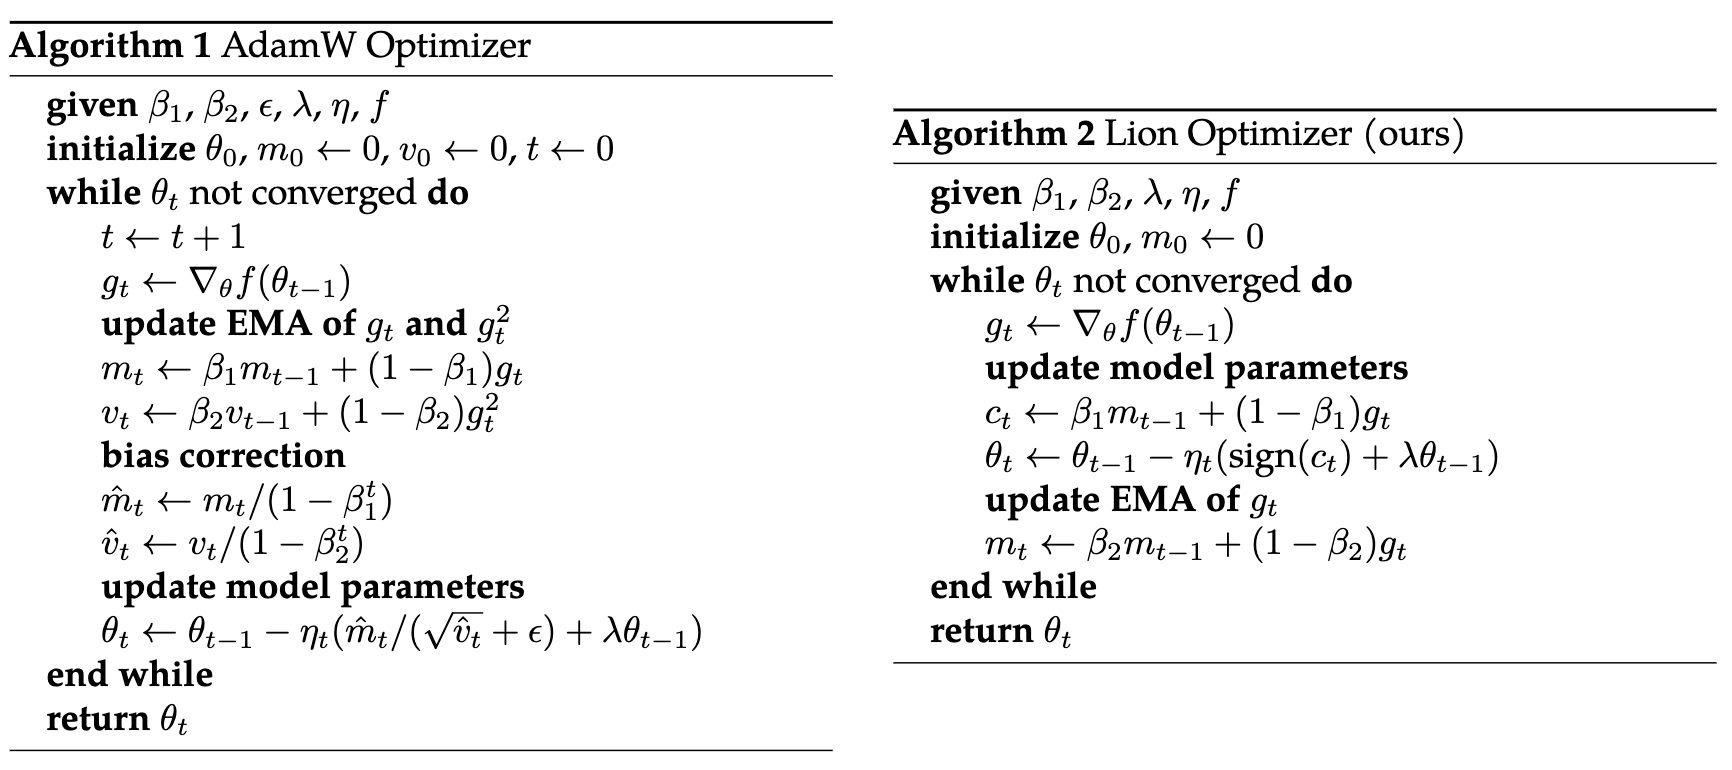

In [7]:
# Display the image without frame and with higher resolution
display(Image(filename='lion_figure.PNG', width=900))

In [88]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [89]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [90]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [94]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weights=True)

In [95]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [96]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [97]:
# Charger le GPU pour le modèle
model = model.to(device)

In [42]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [99]:
# Définition de l'optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [100]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 91477.5756 train Acc: 0.1320: 100%|██████████| 226/226 [01:24<00:00,  2.67it/s]


train Loss: 6.3504 train Acc: 0.1320


val Loss: 12717.9142 val Acc: 0.4312: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


val Loss: 4.1198 val Acc: 0.4312
Epoch 2/20


train Loss: 78309.7925 train Acc: 0.4371: 100%|██████████| 226/226 [01:25<00:00,  2.63it/s]


train Loss: 5.4363 train Acc: 0.4371


val Loss: 10703.9666 val Acc: 0.5750: 100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


val Loss: 3.4674 val Acc: 0.5750
Epoch 3/20


train Loss: 67103.2770 train Acc: 0.5563: 100%|██████████| 226/226 [01:26<00:00,  2.62it/s]


train Loss: 4.6583 train Acc: 0.5563


val Loss: 8978.2559 val Acc: 0.6544: 100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


val Loss: 2.9084 val Acc: 0.6544
Epoch 4/20


train Loss: 57756.4274 train Acc: 0.6218: 100%|██████████| 226/226 [01:28<00:00,  2.54it/s]


train Loss: 4.0095 train Acc: 0.6218


val Loss: 7663.9735 val Acc: 0.6761: 100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


val Loss: 2.4827 val Acc: 0.6761
Epoch 5/20


train Loss: 50721.2882 train Acc: 0.6539: 100%|██████████| 226/226 [01:30<00:00,  2.50it/s]


train Loss: 3.5211 train Acc: 0.6539


val Loss: 6630.8724 val Acc: 0.7136: 100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


val Loss: 2.1480 val Acc: 0.7136
Epoch 6/20


train Loss: 45260.4885 train Acc: 0.6760: 100%|██████████| 226/226 [01:31<00:00,  2.47it/s]


train Loss: 3.1420 train Acc: 0.6760


val Loss: 5792.4416 val Acc: 0.7344: 100%|██████████| 49/49 [00:19<00:00,  2.58it/s]


val Loss: 1.8764 val Acc: 0.7344
Epoch 7/20


train Loss: 41134.7713 train Acc: 0.6859: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 2.8556 train Acc: 0.6859


val Loss: 5185.0017 val Acc: 0.7483: 100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


val Loss: 1.6796 val Acc: 0.7483
Epoch 8/20


train Loss: 38061.9323 train Acc: 0.6977: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 2.6423 train Acc: 0.6977


val Loss: 4663.0304 val Acc: 0.7464: 100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


val Loss: 1.5105 val Acc: 0.7464
Epoch 9/20


train Loss: 35293.1241 train Acc: 0.7078: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 2.4501 train Acc: 0.7078


val Loss: 4384.8585 val Acc: 0.7554: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.4204 val Acc: 0.7554
Epoch 10/20


train Loss: 33308.9041 train Acc: 0.7129: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.3123 train Acc: 0.7129


val Loss: 4403.5158 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


val Loss: 1.4265 val Acc: 0.7340
Epoch 11/20


train Loss: 31751.6944 train Acc: 0.7166: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.2042 train Acc: 0.7166


val Loss: 3952.8103 val Acc: 0.7671: 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


val Loss: 1.2805 val Acc: 0.7671
Epoch 12/20


train Loss: 30526.8150 train Acc: 0.7191: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 2.1192 train Acc: 0.7191


val Loss: 3895.5093 val Acc: 0.7535: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 1.2619 val Acc: 0.7535
Epoch 13/20


train Loss: 29192.2269 train Acc: 0.7235: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 2.0265 train Acc: 0.7235


val Loss: 3644.0809 val Acc: 0.7723: 100%|██████████| 49/49 [00:20<00:00,  2.38it/s]


val Loss: 1.1805 val Acc: 0.7723
Epoch 14/20


train Loss: 28582.5954 train Acc: 0.7211: 100%|██████████| 226/226 [01:38<00:00,  2.30it/s]


train Loss: 1.9842 train Acc: 0.7211


val Loss: 3371.1500 val Acc: 0.7807: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


val Loss: 1.0920 val Acc: 0.7807
Epoch 15/20


train Loss: 27653.0957 train Acc: 0.7313: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 1.9197 train Acc: 0.7313


val Loss: 3419.8351 val Acc: 0.7690: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.1078 val Acc: 0.7690
Epoch 16/20


train Loss: 26871.9739 train Acc: 0.7356: 100%|██████████| 226/226 [01:37<00:00,  2.32it/s]


train Loss: 1.8655 train Acc: 0.7356


val Loss: 3336.6170 val Acc: 0.7690: 100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


val Loss: 1.0809 val Acc: 0.7690
Epoch 17/20


train Loss: 26461.9087 train Acc: 0.7286: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.8370 train Acc: 0.7286


val Loss: 3227.9161 val Acc: 0.7742: 100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


val Loss: 1.0456 val Acc: 0.7742
Epoch 18/20


train Loss: 25674.4455 train Acc: 0.7356: 100%|██████████| 226/226 [01:38<00:00,  2.29it/s]


train Loss: 1.7823 train Acc: 0.7356


val Loss: 3351.0333 val Acc: 0.7632: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.0855 val Acc: 0.7632
Epoch 19/20


train Loss: 25400.7368 train Acc: 0.7340: 100%|██████████| 226/226 [01:40<00:00,  2.25it/s]


train Loss: 1.7633 train Acc: 0.7340


val Loss: 3241.3255 val Acc: 0.7642: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.0500 val Acc: 0.7642
Epoch 20/20


train Loss: 25106.3547 train Acc: 0.7309: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.7429 train Acc: 0.7309


val Loss: 3243.3617 val Acc: 0.7674: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]

val Loss: 1.0507 val Acc: 0.7674


In [101]:
# Obtenir le nom des classes
class_names = dataset.classes

In [102]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.84      1.00      0.91        32
           African_hunting_dog       0.77      1.00      0.87        20
                      Airedale       0.76      0.90      0.82        31
American_Staffordshire_terrier       0.55      0.60      0.57        20
                   Appenzeller       0.75      0.60      0.67        25
            Australian_terrier       0.79      0.82      0.81        28
            Bedlington_terrier       0.88      0.93      0.90        30
          Bernese_mountain_dog       0.91      0.94      0.92        32
              Blenheim_spaniel       0.85      0.85      0.85        27
                 Border_collie       0.69      0.75      0.72        24
                Border_terrier       1.00      0.97      0.99        34
                   Boston_bull       0.81      0.88      0.84        24
          Bouvier_des_Flandres       0.70      0.76      0.73  

In [103]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.80      0.88      0.83        40
           African_hunting_dog       0.72      1.00      0.84        21
                      Airedale       0.77      0.67      0.71        30
American_Staffordshire_terrier       0.59      0.54      0.57        24
                   Appenzeller       0.93      0.45      0.60        29
            Australian_terrier       0.68      0.81      0.74        26
            Bedlington_terrier       0.67      0.81      0.73        27
          Bernese_mountain_dog       0.71      0.90      0.79        30
              Blenheim_spaniel       0.78      0.84      0.81        25
                 Border_collie       0.67      0.74      0.70        19
                Border_terrier       0.81      0.85      0.83        26
                   Boston_bull       0.89      0.89      0.89        28
          Bouvier_des_Flandres       0.68      0.72      0.70  

### 2.1.2 InceptionV3 Lion
<a href="#toc">Revenir en haut</a>

In [ ]:
pip install lion-pytorch

In [54]:
from lion_pytorch import Lion

In [106]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [107]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [108]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weigths=True)

In [110]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [111]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [112]:
# Charger le GPU pour le modèle
model = model.to(device)

In [113]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [114]:
# Définition de l'optimizer
optimizer = Lion(model.parameters(), lr=0.001, weight_decay=0.01)

In [115]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 39075.7667 train Acc: 0.6011: 100%|██████████| 226/226 [01:35<00:00,  2.37it/s]


train Loss: 2.7127 train Acc: 0.6011


val Loss: 4467.1320 val Acc: 0.7146: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 1.4471 val Acc: 0.7146
Epoch 2/20


train Loss: 43049.7900 train Acc: 0.6718: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 2.9885 train Acc: 0.6718


val Loss: 5374.2457 val Acc: 0.7140: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 1.7409 val Acc: 0.7140
Epoch 3/20


train Loss: 49682.9139 train Acc: 0.6639: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 3.4490 train Acc: 0.6639


val Loss: 6209.1499 val Acc: 0.7185: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 2.0114 val Acc: 0.7185
Epoch 4/20


train Loss: 55486.8610 train Acc: 0.6557: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 3.8519 train Acc: 0.6557


val Loss: 6730.0811 val Acc: 0.7204: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 2.1801 val Acc: 0.7204
Epoch 5/20


train Loss: 58526.3153 train Acc: 0.6632: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 4.0629 train Acc: 0.6632


val Loss: 7299.6559 val Acc: 0.7224: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 2.3646 val Acc: 0.7224
Epoch 6/20


train Loss: 60066.1875 train Acc: 0.6708: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 4.1698 train Acc: 0.6708


val Loss: 7534.3733 val Acc: 0.7172: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 2.4407 val Acc: 0.7172
Epoch 7/20


train Loss: 62753.5659 train Acc: 0.6705: 100%|██████████| 226/226 [01:33<00:00,  2.42it/s]


train Loss: 4.3564 train Acc: 0.6705


val Loss: 8409.8172 val Acc: 0.7208: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 2.7243 val Acc: 0.7208
Epoch 8/20


train Loss: 64509.4471 train Acc: 0.6704: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.4783 train Acc: 0.6704


val Loss: 7599.6772 val Acc: 0.7447: 100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


val Loss: 2.4618 val Acc: 0.7447
Epoch 9/20


train Loss: 68260.1858 train Acc: 0.6728: 100%|██████████| 226/226 [01:33<00:00,  2.41it/s]


train Loss: 4.7386 train Acc: 0.6728


val Loss: 8138.9992 val Acc: 0.7467: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 2.6365 val Acc: 0.7467
Epoch 10/20


train Loss: 68043.9062 train Acc: 0.6802: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.7236 train Acc: 0.6802


val Loss: 9520.8978 val Acc: 0.7185: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 3.0842 val Acc: 0.7185
Epoch 11/20


train Loss: 70573.9080 train Acc: 0.6807: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.8993 train Acc: 0.6807


val Loss: 8559.1816 val Acc: 0.7311: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 2.7727 val Acc: 0.7311
Epoch 12/20


train Loss: 70976.6009 train Acc: 0.6825: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 4.9272 train Acc: 0.6825


val Loss: 9107.4040 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 2.9502 val Acc: 0.7340
Epoch 13/20


train Loss: 74278.4938 train Acc: 0.6835: 100%|██████████| 226/226 [01:33<00:00,  2.41it/s]


train Loss: 5.1564 train Acc: 0.6835


val Loss: 9329.5360 val Acc: 0.7340: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 3.0222 val Acc: 0.7340
Epoch 14/20


train Loss: 74888.0640 train Acc: 0.6817: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.1988 train Acc: 0.6817


val Loss: 9686.3769 val Acc: 0.7331: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.1378 val Acc: 0.7331
Epoch 15/20


train Loss: 75709.2416 train Acc: 0.6834: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.2558 train Acc: 0.6834


val Loss: 10361.6238 val Acc: 0.7256: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 3.3565 val Acc: 0.7256
Epoch 16/20


train Loss: 76215.6702 train Acc: 0.6884: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.2909 train Acc: 0.6884


val Loss: 10453.1406 val Acc: 0.7357: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.3862 val Acc: 0.7357
Epoch 17/20


train Loss: 76811.1957 train Acc: 0.6919: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.3323 train Acc: 0.6919


val Loss: 10830.3946 val Acc: 0.7188: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


val Loss: 3.5084 val Acc: 0.7188
Epoch 18/20


train Loss: 78086.9752 train Acc: 0.6935: 100%|██████████| 226/226 [01:34<00:00,  2.39it/s]


train Loss: 5.4208 train Acc: 0.6935


val Loss: 11338.5849 val Acc: 0.7263: 100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


val Loss: 3.6730 val Acc: 0.7263
Epoch 19/20


train Loss: 78362.4733 train Acc: 0.6901: 100%|██████████| 226/226 [01:35<00:00,  2.37it/s]


train Loss: 5.4399 train Acc: 0.6901


val Loss: 10776.4820 val Acc: 0.7289: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


val Loss: 3.4909 val Acc: 0.7289
Epoch 20/20


train Loss: 77592.4241 train Acc: 0.6938: 100%|██████████| 226/226 [01:37<00:00,  2.33it/s]


train Loss: 5.3865 train Acc: 0.6938


val Loss: 9401.0592 val Acc: 0.7480: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]

val Loss: 3.0454 val Acc: 0.7480


In [116]:
# Obtenir le nom des classes
class_names = dataset.classes

In [117]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.81      0.76      0.79        29
           African_hunting_dog       0.92      0.92      0.92        24
                      Airedale       0.67      0.82      0.74        38
American_Staffordshire_terrier       0.73      0.65      0.69        17
                   Appenzeller       0.67      0.48      0.56        29
            Australian_terrier       0.62      0.71      0.67        28
            Bedlington_terrier       0.94      0.76      0.84        21
          Bernese_mountain_dog       0.74      0.86      0.79        29
              Blenheim_spaniel       0.96      0.77      0.86        35
                 Border_collie       0.57      0.35      0.43        23
                Border_terrier       0.81      0.86      0.83        29
                   Boston_bull       0.90      0.62      0.73        29
          Bouvier_des_Flandres       0.68      0.65      0.67  

In [118]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.85      0.88      0.86        40
           African_hunting_dog       0.80      0.80      0.80        25
                      Airedale       0.70      0.81      0.75        26
American_Staffordshire_terrier       0.59      0.62      0.61        16
                   Appenzeller       0.88      0.54      0.67        26
            Australian_terrier       0.71      0.85      0.77        26
            Bedlington_terrier       0.88      0.75      0.81        28
          Bernese_mountain_dog       0.82      0.80      0.81        35
              Blenheim_spaniel       0.92      0.89      0.91        27
                 Border_collie       0.73      0.33      0.46        24
                Border_terrier       0.64      0.88      0.74        24
                   Boston_bull       0.96      0.74      0.84        31
          Bouvier_des_Flandres       0.93      0.57      0.70  

### 2.1.3 InceptionV3 Adam
<a href="#toc">Revenir en haut</a>

In [56]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=train_transforms)

In [57]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [59]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [60]:
# Charger le modèle pré-entraîné
model = models.inception_v3(weights=True)

In [61]:
# Geler les paramètres du modèle pré-entraîné
for param in model.parameters():
    param.requires_grad = False

In [62]:
# Remplacer la dernière couche pour s'adapter à notre problème de classification
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 120)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

In [63]:
# Charger le GPU pour le modèle
model = model.to(device)

In [64]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [67]:
# Définition de l'optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [78]:
# Train and validate
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 26332.0547 train Acc: 0.7216: 100%|██████████| 226/226 [01:24<00:00,  2.69it/s]


train Loss: 1.8280 train Acc: 0.7216


val Loss: 3473.3072 val Acc: 0.7477: 100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


val Loss: 1.1251 val Acc: 0.7477
Epoch 2/20


train Loss: 25923.2202 train Acc: 0.7215: 100%|██████████| 226/226 [01:25<00:00,  2.64it/s]


train Loss: 1.7996 train Acc: 0.7215


val Loss: 3532.7850 val Acc: 0.7399: 100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


val Loss: 1.1444 val Acc: 0.7399
Epoch 3/20


train Loss: 26792.4203 train Acc: 0.7079: 100%|██████████| 226/226 [01:28<00:00,  2.55it/s]


train Loss: 1.8599 train Acc: 0.7079


val Loss: 3377.5966 val Acc: 0.7509: 100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


val Loss: 1.0941 val Acc: 0.7509
Epoch 4/20


train Loss: 26406.9624 train Acc: 0.7175: 100%|██████████| 226/226 [01:32<00:00,  2.43it/s]


train Loss: 1.8332 train Acc: 0.7175


val Loss: 3445.2864 val Acc: 0.7480: 100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


val Loss: 1.1161 val Acc: 0.7480
Epoch 5/20


train Loss: 26613.0307 train Acc: 0.7104: 100%|██████████| 226/226 [01:34<00:00,  2.40it/s]


train Loss: 1.8475 train Acc: 0.7104


val Loss: 3494.2511 val Acc: 0.7454: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


val Loss: 1.1319 val Acc: 0.7454
Epoch 6/20


train Loss: 26506.8477 train Acc: 0.7131: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8401 train Acc: 0.7131


val Loss: 3630.8394 val Acc: 0.7302: 100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


val Loss: 1.1762 val Acc: 0.7302
Epoch 7/20


train Loss: 26616.7885 train Acc: 0.7154: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8477 train Acc: 0.7154


val Loss: 3597.0978 val Acc: 0.7302: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


val Loss: 1.1652 val Acc: 0.7302
Epoch 8/20


train Loss: 26482.7343 train Acc: 0.7139: 100%|██████████| 226/226 [01:34<00:00,  2.38it/s]


train Loss: 1.8384 train Acc: 0.7139


val Loss: 3568.1434 val Acc: 0.7324: 100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


val Loss: 1.1559 val Acc: 0.7324
Epoch 9/20


train Loss: 26509.7370 train Acc: 0.7175: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8403 train Acc: 0.7175


val Loss: 3488.8891 val Acc: 0.7357: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


val Loss: 1.1302 val Acc: 0.7357
Epoch 10/20


train Loss: 26335.1106 train Acc: 0.7198: 100%|██████████| 226/226 [01:35<00:00,  2.36it/s]


train Loss: 1.8282 train Acc: 0.7198


val Loss: 3624.6583 val Acc: 0.7331: 100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


val Loss: 1.1742 val Acc: 0.7331
Epoch 11/20


train Loss: 26291.4132 train Acc: 0.7167: 100%|██████████| 226/226 [01:36<00:00,  2.34it/s]


train Loss: 1.8252 train Acc: 0.7167


val Loss: 3457.3499 val Acc: 0.7357: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


val Loss: 1.1200 val Acc: 0.7357
Epoch 12/20


train Loss: 26380.2620 train Acc: 0.7159: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8313 train Acc: 0.7159


val Loss: 3646.5298 val Acc: 0.7311: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


val Loss: 1.1813 val Acc: 0.7311
Epoch 13/20


train Loss: 26359.5819 train Acc: 0.7165: 100%|██████████| 226/226 [01:37<00:00,  2.31it/s]


train Loss: 1.8299 train Acc: 0.7165


val Loss: 3599.8625 val Acc: 0.7266: 100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


val Loss: 1.1661 val Acc: 0.7266
Epoch 14/20


train Loss: 26397.4712 train Acc: 0.7200: 100%|██████████| 226/226 [01:36<00:00,  2.33it/s]


train Loss: 1.8325 train Acc: 0.7200


val Loss: 3537.1634 val Acc: 0.7434: 100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


val Loss: 1.1458 val Acc: 0.7434
Epoch 15/20


train Loss: 26616.7504 train Acc: 0.7146: 100%|██████████| 226/226 [01:39<00:00,  2.27it/s]


train Loss: 1.8477 train Acc: 0.7146


val Loss: 3367.6869 val Acc: 0.7467: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


val Loss: 1.0909 val Acc: 0.7467
Epoch 16/20


train Loss: 26407.4268 train Acc: 0.7171: 100%|██████████| 226/226 [01:35<00:00,  2.38it/s]


train Loss: 1.8332 train Acc: 0.7171


val Loss: 3372.2735 val Acc: 0.7502: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


val Loss: 1.0924 val Acc: 0.7502
Epoch 17/20


train Loss: 26783.8335 train Acc: 0.7112: 100%|██████████| 226/226 [01:33<00:00,  2.42it/s]


train Loss: 1.8593 train Acc: 0.7112


val Loss: 3477.2499 val Acc: 0.7408: 100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


val Loss: 1.1264 val Acc: 0.7408
Epoch 18/20


train Loss: 26317.9809 train Acc: 0.7188: 100%|██████████| 226/226 [01:39<00:00,  2.26it/s]


train Loss: 1.8270 train Acc: 0.7188


val Loss: 3400.9371 val Acc: 0.7470: 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


val Loss: 1.1017 val Acc: 0.7470
Epoch 19/20


train Loss: 26337.1887 train Acc: 0.7202: 100%|██████████| 226/226 [01:42<00:00,  2.21it/s]


train Loss: 1.8283 train Acc: 0.7202


val Loss: 3650.2441 val Acc: 0.7328: 100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


val Loss: 1.1825 val Acc: 0.7328
Epoch 20/20


train Loss: 26561.4844 train Acc: 0.7146: 100%|██████████| 226/226 [01:39<00:00,  2.28it/s]


train Loss: 1.8439 train Acc: 0.7146


val Loss: 3533.4813 val Acc: 0.7412: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]

val Loss: 1.1446 val Acc: 0.7412


In [86]:
# Obtenir le nom des classes
class_names = dataset.classes

In [82]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.87      0.96      0.92        28
           African_hunting_dog       0.89      0.96      0.93        26
                      Airedale       0.92      0.48      0.63        23
American_Staffordshire_terrier       0.74      0.57      0.64        30
                   Appenzeller       0.79      0.66      0.72        29
            Australian_terrier       0.78      0.81      0.79        26
            Bedlington_terrier       0.51      0.93      0.66        29
          Bernese_mountain_dog       0.87      0.74      0.80        35
              Blenheim_spaniel       0.83      0.83      0.83        29
                 Border_collie       0.55      0.85      0.67        20
                Border_terrier       0.91      0.95      0.93        22
                   Boston_bull       1.00      0.91      0.95        34
          Bouvier_des_Flandres       0.39      0.86      0.54  

In [87]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.86      0.77      0.81        39
           African_hunting_dog       0.86      0.97      0.91        32
                      Airedale       0.90      0.93      0.91        28
American_Staffordshire_terrier       0.73      0.57      0.64        28
                   Appenzeller       0.67      0.55      0.60        11
            Australian_terrier       0.71      0.75      0.73        32
            Bedlington_terrier       0.65      0.97      0.78        29
          Bernese_mountain_dog       0.98      0.91      0.94        45
              Blenheim_spaniel       0.96      0.76      0.85        33
                 Border_collie       0.57      0.76      0.65        17
                Border_terrier       0.91      0.95      0.93        21
                   Boston_bull       0.75      0.60      0.67        25
          Bouvier_des_Flandres       0.36      1.00      0.53  

## <a name="C22">2.2 CoaT</a>
<a href="#toc">Revenir en haut</a>

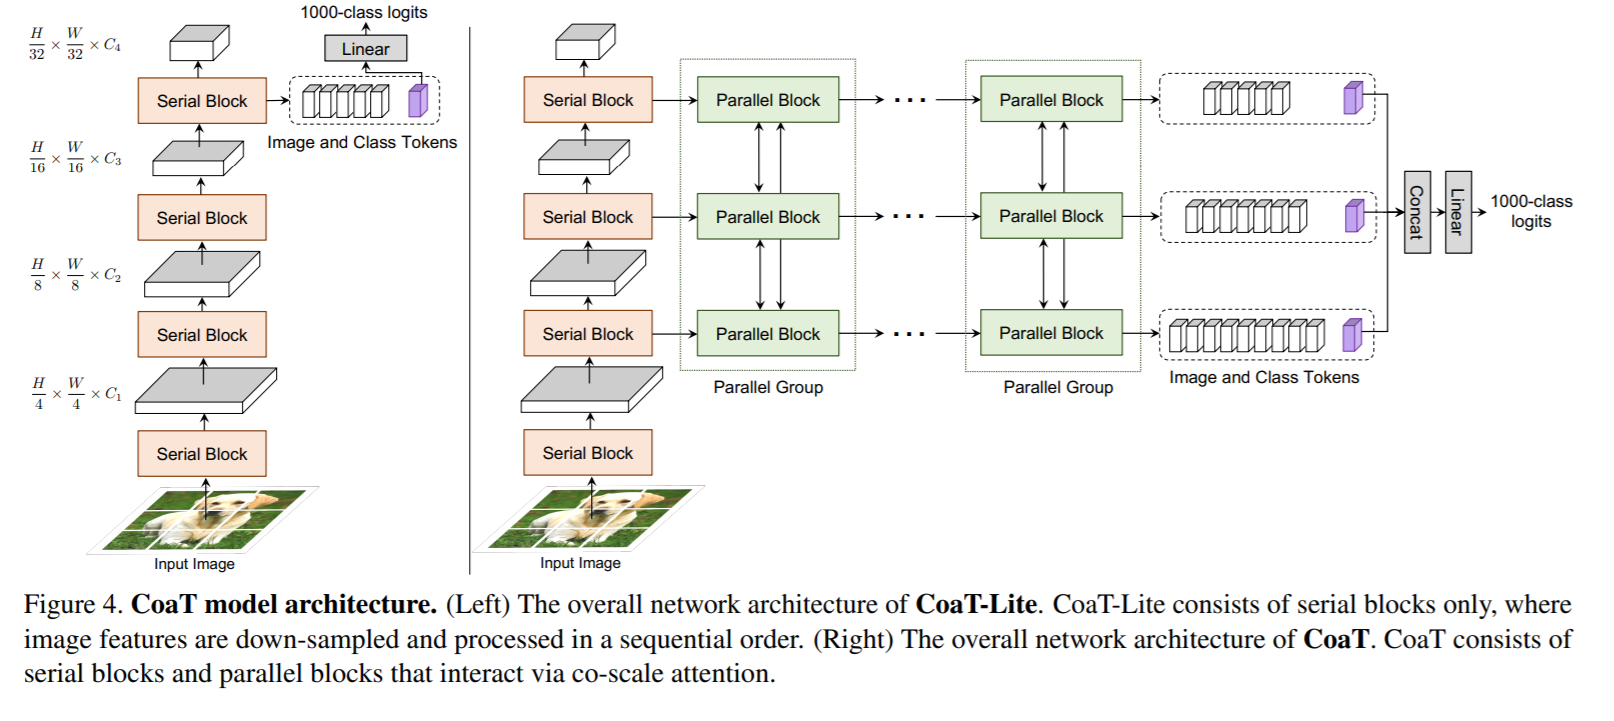

In [5]:
# Display the image without frame and with higher resolution
display(Image(filename='model.PNG', width=1000))

Nous avons une architecture de réseau convolutif avec une structure de transformer. Pour créer ce modèle en utilisant PyTorch, nous devons comprendre chaque composant.

L'image montre que le modèle CoaT (Convolutional and Transformer) est composé de plusieurs couches. Les composants principaux de ce modèle sont :

    - Une couche de convolution pour extraire les caractéristiques de l'image en entrée.
    - Un bloc de Transformer pour le traitement des caractéristiques extraites.
    - Une couche de Pooling pour réduire la dimensionnalité.
    - Une couche entièrement connectée (FC) pour la classification.
    
Voici la retransmission du schéma en code :

In [4]:
class CoaT(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(CoaT, self).__init__()
        
        # Définition de la couche de convolution
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        
        # Définition du block Transformer
        self.transformer = Transformer(d_model=512, nhead=8)
        
        # Définition de la couche de pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Définition de la couche entièrement connectée pour la classification
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Passer l'input vers la couche de convolution
        x = self.conv1(x)
        
        # passer l'output vers le Transformer block
        x = self.transformer(x)
        
        # passer l'output à travers la couche de pooling
        x = self.pool(x)
        
        # applatir l'output
        x = x.view(x.size(0), -1)
        
        # passer l'output à travers la couche entièrement connectée
        x = self.fc(x)
        
        return x

In [165]:
def train_and_validate(model, criterion, optimizer, epochs=20):
    history = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                dataloader = train_loader
            else:
                model.eval()   
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            pbar = tqdm(dataloader)

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                pbar.set_description(f'{phase} Loss: {running_loss:.4f} {phase} Acc: {running_corrects.double()/len(dataloader.dataset):.4f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

            history.append({'epoch': epoch+1, 'phase': phase, 'loss': epoch_loss, 'acc': epoch_acc})

    return model, history

In [11]:
pip install einops

     ---------------------------------------- 0.0/42.2 kB ? eta -:--:--
     --------------------------- ---------- 30.7/42.2 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 42.2/42.2 kB 507.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [60]:
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
import cv2
from coat import CoaT
import module
from torch.optim import lr_scheduler
import copy

In [167]:
# Définir le transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [168]:
# Charger les images
dataset = datasets.ImageFolder("Images", transform=transform)

In [169]:
# Split le dataset en train, validation et test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [170]:
# Creer les data loaders for training, validation et test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [171]:
# On charge notre modèle CoaT
model = CoaT(3, 224, 120)

In [174]:
# chargement du GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.serial_mlp_head[1] = model.serial_mlp_head[1].to(device)
model = model.to(device)

In [175]:
# Définition de la loss
criterion = nn.CrossEntropyLoss()

In [183]:
# Définition de l'optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [184]:
# Train and validate the model
model, history = train_and_validate(model, criterion, optimizer, epochs=20)

Epoch 1/20


train Loss: 79687.2952 train Acc: 0.0208: 100%|██████████| 226/226 [00:58<00:00,  3.87it/s]


train Loss: 5.5319 train Acc: 0.0208


val Loss: 17187.3877 val Acc: 0.0146: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


val Loss: 5.5677 val Acc: 0.0146
Epoch 2/20


train Loss: 77560.1900 train Acc: 0.0236: 100%|██████████| 226/226 [00:59<00:00,  3.81it/s]


train Loss: 5.3843 train Acc: 0.0236


val Loss: 17429.6436 val Acc: 0.0168: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


val Loss: 5.6461 val Acc: 0.0168
Epoch 3/20


train Loss: 76568.2999 train Acc: 0.0292: 100%|██████████| 226/226 [00:58<00:00,  3.86it/s]


train Loss: 5.3154 train Acc: 0.0292


val Loss: 17722.1558 val Acc: 0.0198: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


val Loss: 5.7409 val Acc: 0.0198
Epoch 4/20


train Loss: 77001.8444 train Acc: 0.0285: 100%|██████████| 226/226 [00:59<00:00,  3.83it/s]


train Loss: 5.3455 train Acc: 0.0285


val Loss: 17201.7786 val Acc: 0.0230: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]


val Loss: 5.5723 val Acc: 0.0230
Epoch 5/20


train Loss: 75899.1949 train Acc: 0.0342: 100%|██████████| 226/226 [00:59<00:00,  3.82it/s]


train Loss: 5.2689 train Acc: 0.0342


val Loss: 17389.9468 val Acc: 0.0201: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


val Loss: 5.6333 val Acc: 0.0201
Epoch 6/20


train Loss: 76726.5632 train Acc: 0.0316: 100%|██████████| 226/226 [00:59<00:00,  3.82it/s]


train Loss: 5.3264 train Acc: 0.0316


val Loss: 17594.8022 val Acc: 0.0220: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


val Loss: 5.6996 val Acc: 0.0220
Epoch 7/20


train Loss: 75409.3667 train Acc: 0.0344: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2349 train Acc: 0.0344


val Loss: 17383.1246 val Acc: 0.0266: 100%|██████████| 49/49 [00:12<00:00,  3.80it/s]


val Loss: 5.6311 val Acc: 0.0266
Epoch 8/20


train Loss: 76068.5371 train Acc: 0.0340: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2807 train Acc: 0.0340


val Loss: 17028.2829 val Acc: 0.0217: 100%|██████████| 49/49 [00:12<00:00,  3.78it/s]


val Loss: 5.5161 val Acc: 0.0217
Epoch 9/20


train Loss: 75340.4232 train Acc: 0.0379: 100%|██████████| 226/226 [01:00<00:00,  3.76it/s]


train Loss: 5.2302 train Acc: 0.0379


val Loss: 17519.5531 val Acc: 0.0198: 100%|██████████| 49/49 [00:12<00:00,  3.83it/s]


val Loss: 5.6753 val Acc: 0.0198
Epoch 10/20


train Loss: 74944.0414 train Acc: 0.0383: 100%|██████████| 226/226 [00:59<00:00,  3.77it/s]


train Loss: 5.2026 train Acc: 0.0383


val Loss: 17260.0679 val Acc: 0.0314: 100%|██████████| 49/49 [00:13<00:00,  3.72it/s]


val Loss: 5.5912 val Acc: 0.0314
Epoch 11/20


train Loss: 75041.6559 train Acc: 0.0355: 100%|██████████| 226/226 [01:00<00:00,  3.76it/s]


train Loss: 5.2094 train Acc: 0.0355


val Loss: 17070.5013 val Acc: 0.0282: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


val Loss: 5.5298 val Acc: 0.0282
Epoch 12/20


train Loss: 74921.3075 train Acc: 0.0385: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.2011 train Acc: 0.0385


val Loss: 17305.6481 val Acc: 0.0214: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


val Loss: 5.6060 val Acc: 0.0214
Epoch 13/20


train Loss: 75053.7956 train Acc: 0.0376: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.2103 train Acc: 0.0376


val Loss: 17602.4481 val Acc: 0.0211: 100%|██████████| 49/49 [00:12<00:00,  3.79it/s]


val Loss: 5.7021 val Acc: 0.0211
Epoch 14/20


train Loss: 75323.1264 train Acc: 0.0405: 100%|██████████| 226/226 [01:00<00:00,  3.73it/s]


train Loss: 5.2290 train Acc: 0.0405


val Loss: 17453.0693 val Acc: 0.0217: 100%|██████████| 49/49 [00:13<00:00,  3.72it/s]


val Loss: 5.6537 val Acc: 0.0217
Epoch 15/20


train Loss: 74542.1337 train Acc: 0.0423: 100%|██████████| 226/226 [01:01<00:00,  3.70it/s]


train Loss: 5.1747 train Acc: 0.0423


val Loss: 16613.9619 val Acc: 0.0324: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


val Loss: 5.3819 val Acc: 0.0324
Epoch 16/20


train Loss: 74483.6617 train Acc: 0.0418: 100%|██████████| 226/226 [01:00<00:00,  3.73it/s]


train Loss: 5.1707 train Acc: 0.0418


val Loss: 17598.4774 val Acc: 0.0285: 100%|██████████| 49/49 [00:13<00:00,  3.76it/s]


val Loss: 5.7008 val Acc: 0.0285
Epoch 17/20


train Loss: 74628.8021 train Acc: 0.0412: 100%|██████████| 226/226 [01:00<00:00,  3.71it/s]


train Loss: 5.1808 train Acc: 0.0412


val Loss: 17322.4355 val Acc: 0.0233: 100%|██████████| 49/49 [00:12<00:00,  3.81it/s]


val Loss: 5.6114 val Acc: 0.0233
Epoch 18/20


train Loss: 74254.4851 train Acc: 0.0432: 100%|██████████| 226/226 [01:01<00:00,  3.67it/s]


train Loss: 5.1548 train Acc: 0.0432


val Loss: 17089.7363 val Acc: 0.0282: 100%|██████████| 49/49 [00:13<00:00,  3.70it/s]


val Loss: 5.5360 val Acc: 0.0282
Epoch 19/20


train Loss: 74606.3085 train Acc: 0.0421: 100%|██████████| 226/226 [01:01<00:00,  3.66it/s]


train Loss: 5.1792 train Acc: 0.0421


val Loss: 17708.1871 val Acc: 0.0230: 100%|██████████| 49/49 [00:13<00:00,  3.75it/s]


val Loss: 5.7364 val Acc: 0.0230
Epoch 20/20


train Loss: 74661.5531 train Acc: 0.0428: 100%|██████████| 226/226 [01:01<00:00,  3.69it/s]


train Loss: 5.1830 train Acc: 0.0428


val Loss: 17125.1429 val Acc: 0.0327: 100%|██████████| 49/49 [00:13<00:00,  3.69it/s]

val Loss: 5.5475 val Acc: 0.0327


In [185]:
# Obtenir le nom des classes
class_names = dataset.classes

In [186]:
# Évaluer le modèle sur l'ensemble de validation
report = evaluate_model(model, val_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00        46
           African_hunting_dog       0.10      0.22      0.14        18
                      Airedale       0.12      0.03      0.05        31
American_Staffordshire_terrier       0.00      0.00      0.00        13
                   Appenzeller       0.00      0.00      0.00        18
            Australian_terrier       0.03      0.03      0.03        32
            Bedlington_terrier       0.17      0.04      0.07        24
          Bernese_mountain_dog       0.00      0.00      0.00        35
              Blenheim_spaniel       0.04      0.17      0.07        35
                 Border_collie       0.00      0.00      0.00        21
                Border_terrier       0.00      0.00      0.00        27
                   Boston_bull       0.02      0.13      0.04        23
          Bouvier_des_Flandres       0.00      0.00      0.00  

C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
# Évaluer le modèle sur l'ensemble de test
report = evaluate_model(model, test_loader, class_names, device)
print(report)

                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00        41
           African_hunting_dog       0.06      0.09      0.07        22
                      Airedale       0.00      0.00      0.00        36
American_Staffordshire_terrier       0.00      0.00      0.00        31
                   Appenzeller       0.00      0.00      0.00        21
            Australian_terrier       0.00      0.00      0.00        32
            Bedlington_terrier       0.00      0.00      0.00        23
          Bernese_mountain_dog       0.00      0.00      0.00        30
              Blenheim_spaniel       0.04      0.24      0.06        21
                 Border_collie       0.00      0.00      0.00        22
                Border_terrier       0.00      0.00      0.00        24
                   Boston_bull       0.01      0.03      0.01        29
          Bouvier_des_Flandres       0.00      0.00      0.00  

C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\envs\SOTA_Torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# <a name="C23">2.3 ViT</a>
<a href="#toc">Revenir en haut</a>

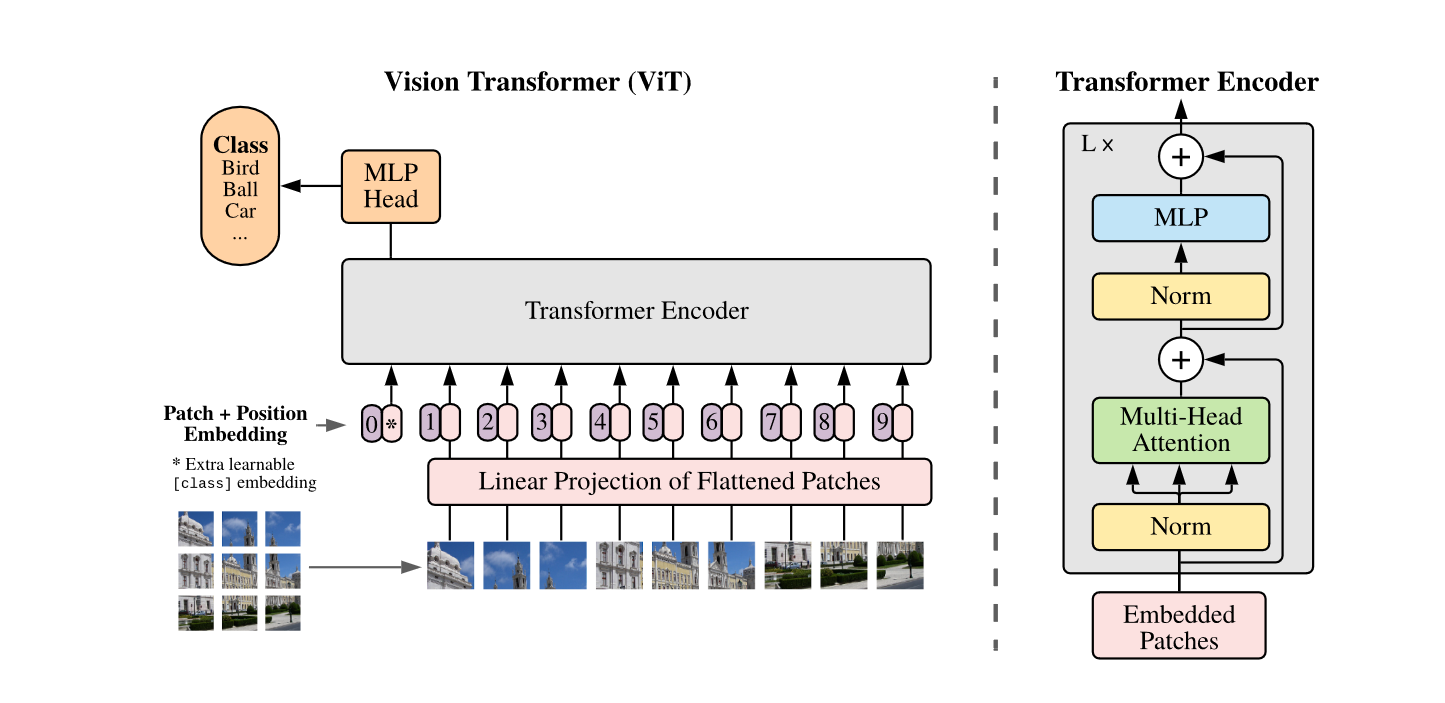

In [56]:
# Display the image without frame and with higher resolution
display(Image(filename='ViT.PNG', width=900))

Explication de ViT : 

    - Découpage en patchs : L'image d'entrée est découpée en petits patchs carrés. Ces patchs sont ensuite aplatis pour être traités par le transformer.

    - Embedding des patchs : Chaque patch aplati est transformé en un vecteur à l'aide d'un réseau de neurones. Cette étape produit un ensemble d'embeddings, un pour chaque patch.

    - Positional Embeddings : Les embeddings de position sont ajoutés aux embeddings des patchs pour donner au modèle une notion de la position relative de chaque patch dans l'image.

    - Transformer Encoder : Les embeddings sont ensuite passés à travers une série de blocs d'encodeurs transformer. Chaque bloc contient une attention multi-têtes et une connexion résiduelle suivie d'une normalisation de couche.

    - MLP Head : Après avoir traversé tous les blocs d'encodeurs, l'embedding du premier patch (souvent appelé le "token de classe") est extrait et passé à travers une tête MLP pour obtenir la prédiction finale.

La quasi totalité du code viens de ce tutoriel :

https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

In [58]:
from tqdm import tqdm, trange

In [27]:
import vit_torch
from vit_torch import MyViT, MyViTBlock, MyMSA

In [28]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [29]:
def forward(self, images):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    tokens = self.linear_mapper(patches)
        
    # Adding classification token to the tokens
    tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
    # Adding positional embedding
    out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)
            
    # Getting the classification token only
    out = out[:, 0]
        
    return self.mlp(out) # Map to output dimension, output category distribution

In [30]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [32]:
# Loading data
transform = ToTensor()

train_set = MNIST(root='DATASET_DIR/train', train=True, download=True, transform=transform)
test_set = MNIST(root='DATASET_DIR/test', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [45]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 20
LR = 0.005

Using device:  cuda (NVIDIA GeForce RTX 3070 Ti Laptop GPU)


### 2.3.1 ViT Adam
<a href="#toc">Revenir en haut</a>

In [50]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    train_corrects = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        
        _, preds = torch.max(y_hat, 1)
        train_corrects += torch.sum(preds == y.data)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = train_corrects.double() / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f} accuracy: {train_accuracy:.2f}")

Epoch 1 in training:  47%|████▋     | 220/469 [01:54<02:15,  1.84it/s]


Epoch 1 in training:  94%|█████████▍| 440/469 [03:50<00:15,  1.83it/s]


Training:   5%|▌         | 1/20 [04:04<1:17:26, 244.57s/it]           

Epoch 1/20 loss: 2.01 accuracy: 0.44



Epoch 2 in training:  47%|████▋     | 221/469 [01:52<02:03,  2.00it/s]


Epoch 2 in training:  94%|█████████▍| 441/469 [03:41<00:14,  1.97it/s]


Training:  10%|█         | 2/20 [07:59<1:11:44, 239.14s/it]           

Epoch 2/20 loss: 1.80 accuracy: 0.66



Epoch 3 in training:  47%|████▋     | 221/469 [01:49<02:04,  1.99it/s]


Epoch 3 in training:  94%|█████████▍| 441/469 [03:38<00:12,  2.19it/s]


Training:  15%|█▌        | 3/20 [11:52<1:06:53, 236.10s/it]           

Epoch 3/20 loss: 1.72 accuracy: 0.74



Epoch 4 in training:  47%|████▋     | 221/469 [01:49<02:08,  1.93it/s]


Epoch 4 in training:  94%|█████████▍| 441/469 [03:39<00:13,  2.00it/s]


Training:  20%|██        | 4/20 [15:46<1:02:45, 235.32s/it]           

Epoch 4/20 loss: 1.69 accuracy: 0.77



Epoch 5 in training:  47%|████▋     | 221/469 [01:50<02:05,  1.98it/s]


Epoch 5 in training:  94%|█████████▍| 441/469 [03:39<00:13,  2.04it/s]


Training:  25%|██▌       | 5/20 [19:40<58:40, 234.67s/it]             

Epoch 5/20 loss: 1.66 accuracy: 0.80



Epoch 6 in training:  47%|████▋     | 221/469 [01:50<01:59,  2.07it/s]


Epoch 6 in training:  94%|█████████▍| 441/469 [03:40<00:14,  1.94it/s]


Training:  30%|███       | 6/20 [23:33<54:41, 234.41s/it]             

Epoch 6/20 loss: 1.65 accuracy: 0.81



Epoch 7 in training:  47%|████▋     | 221/469 [01:51<02:00,  2.05it/s]


Epoch 7 in training:  94%|█████████▍| 441/469 [03:41<00:14,  1.94it/s]


Training:  35%|███▌      | 7/20 [27:29<50:52, 234.82s/it]             

Epoch 7/20 loss: 1.64 accuracy: 0.82



Epoch 8 in training:  47%|████▋     | 221/469 [01:49<02:09,  1.92it/s]


Epoch 8 in training:  94%|█████████▍| 441/469 [03:39<00:14,  1.98it/s]


Training:  40%|████      | 8/20 [31:23<46:53, 234.49s/it]             

Epoch 8/20 loss: 1.64 accuracy: 0.82



Epoch 9 in training:  47%|████▋     | 221/469 [01:50<02:04,  2.00it/s]


Epoch 9 in training:  94%|█████████▍| 441/469 [03:40<00:13,  2.04it/s]


Training:  45%|████▌     | 9/20 [35:17<42:59, 234.46s/it]             

Epoch 9/20 loss: 1.63 accuracy: 0.84



Epoch 10 in training:  46%|████▋     | 218/469 [01:48<01:59,  2.10it/s]


Epoch 10 in training:  93%|█████████▎| 436/469 [03:36<00:16,  2.04it/s]


Training:  50%|█████     | 10/20 [39:10<38:59, 233.96s/it]             

Epoch 10/20 loss: 1.62 accuracy: 0.84



Epoch 11 in training:  46%|████▋     | 218/469 [01:49<01:59,  2.10it/s]


Epoch 11 in training:  93%|█████████▎| 436/469 [03:38<00:16,  1.98it/s]


Training:  55%|█████▌    | 11/20 [43:05<35:07, 234.18s/it]             

Epoch 11/20 loss: 1.62 accuracy: 0.84



Epoch 12 in training:  46%|████▋     | 218/469 [01:51<02:11,  1.90it/s]


Epoch 12 in training:  93%|█████████▎| 436/469 [03:45<00:17,  1.84it/s]


Training:  60%|██████    | 12/20 [47:07<31:33, 236.71s/it]             

Epoch 12/20 loss: 1.61 accuracy: 0.85



Epoch 13 in training:  46%|████▋     | 218/469 [01:53<02:06,  1.99it/s]


Epoch 13 in training:  93%|█████████▎| 436/469 [03:46<00:18,  1.75it/s]


Training:  65%|██████▌   | 13/20 [51:11<27:52, 238.89s/it]             

Epoch 13/20 loss: 1.62 accuracy: 0.84



Epoch 14 in training:  46%|████▋     | 218/469 [01:56<02:09,  1.93it/s]


Epoch 14 in training:  93%|█████████▎| 436/469 [03:51<00:17,  1.91it/s]


Training:  70%|███████   | 14/20 [55:20<24:10, 241.77s/it]             

Epoch 14/20 loss: 1.61 accuracy: 0.85



Epoch 15 in training:  46%|████▋     | 218/469 [01:56<02:16,  1.83it/s]


Epoch 15 in training:  93%|█████████▎| 436/469 [03:50<00:17,  1.89it/s]


Training:  75%|███████▌  | 15/20 [59:28<20:19, 243.80s/it]             

Epoch 15/20 loss: 1.61 accuracy: 0.85



Epoch 16 in training:  46%|████▋     | 218/469 [01:54<02:10,  1.93it/s]


Epoch 16 in training:  93%|█████████▎| 436/469 [03:50<00:16,  1.99it/s]


Training:  80%|████████  | 16/20 [1:03:35<16:19, 244.84s/it]           

Epoch 16/20 loss: 1.61 accuracy: 0.85



Epoch 17 in training:  46%|████▋     | 218/469 [01:55<02:19,  1.80it/s]


Epoch 17 in training:  93%|█████████▎| 436/469 [03:49<00:18,  1.80it/s]


Training:  85%|████████▌ | 17/20 [1:07:42<12:16, 245.46s/it]           

Epoch 17/20 loss: 1.61 accuracy: 0.85



Epoch 18 in training:  46%|████▋     | 218/469 [01:54<02:15,  1.86it/s]


Epoch 18 in training:  93%|█████████▎| 436/469 [03:47<00:17,  1.89it/s]


Training:  90%|█████████ | 18/20 [1:11:47<08:10, 245.22s/it]           

Epoch 18/20 loss: 1.61 accuracy: 0.85



Epoch 19 in training:  46%|████▋     | 218/469 [01:52<02:02,  2.05it/s]


Epoch 19 in training:  93%|█████████▎| 436/469 [03:45<00:17,  1.85it/s]


Training:  95%|█████████▌| 19/20 [1:15:50<04:04, 244.47s/it]           

Epoch 19/20 loss: 1.61 accuracy: 0.85



Epoch 20 in training:  46%|████▋     | 218/469 [01:54<02:13,  1.88it/s]


Epoch 20 in training:  93%|█████████▎| 436/469 [03:48<00:17,  1.92it/s]


Training: 100%|██████████| 20/20 [1:19:56<00:00, 239.80s/it]           

Epoch 20/20 loss: 1.61 accuracy: 0.85


In [51]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 79/79 [00:38<00:00,  2.08it/s]

Test loss: 1.61
Test accuracy: 85.22%


### 2.3.2 ViT SGD
<a href="#toc">Revenir en haut</a>

In [52]:
# Training loop
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    train_corrects = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        
        _, preds = torch.max(y_hat, 1)
        train_corrects += torch.sum(preds == y.data) 

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = train_corrects.double() / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f} accuracy: {train_accuracy:.2f}")

Epoch 1 in training:  47%|████▋     | 220/469 [01:55<02:11,  1.90it/s]


Epoch 1 in training:  94%|█████████▍| 440/469 [03:50<00:15,  1.88it/s]


Training:   5%|▌         | 1/20 [04:06<1:17:55, 246.05s/it]           

Epoch 1/20 loss: 1.60 accuracy: 0.86



Epoch 2 in training:  47%|████▋     | 221/469 [01:55<02:02,  2.03it/s]


Epoch 2 in training:  94%|█████████▍| 441/469 [03:50<00:15,  1.87it/s]


Training:  10%|█         | 2/20 [08:10<1:13:35, 245.31s/it]           

Epoch 2/20 loss: 1.60 accuracy: 0.86



Epoch 3 in training:  47%|████▋     | 221/469 [01:55<02:12,  1.87it/s]


Epoch 3 in training:  94%|█████████▍| 441/469 [03:51<00:14,  1.98it/s]


Training:  15%|█▌        | 3/20 [12:16<1:09:36, 245.65s/it]           

Epoch 3/20 loss: 1.60 accuracy: 0.86



Epoch 4 in training:  47%|████▋     | 221/469 [01:56<02:19,  1.78it/s]


Epoch 4 in training:  94%|█████████▍| 441/469 [03:51<00:14,  1.92it/s]


Training:  20%|██        | 4/20 [16:23<1:05:33, 245.87s/it]           

Epoch 4/20 loss: 1.60 accuracy: 0.86



Epoch 5 in training:  47%|████▋     | 221/469 [01:54<01:59,  2.08it/s]


Epoch 5 in training:  94%|█████████▍| 441/469 [03:50<00:15,  1.79it/s]


Training:  25%|██▌       | 5/20 [20:28<1:01:27, 245.82s/it]           

Epoch 5/20 loss: 1.61 accuracy: 0.85



Epoch 6 in training:  47%|████▋     | 221/469 [01:58<02:25,  1.70it/s]


Epoch 6 in training:  94%|█████████▍| 441/469 [03:52<00:13,  2.03it/s]


Training:  30%|███       | 6/20 [24:36<57:30, 246.49s/it]             

Epoch 6/20 loss: 1.60 accuracy: 0.86



Epoch 7 in training:  47%|████▋     | 221/469 [01:56<02:13,  1.86it/s]


Epoch 7 in training:  94%|█████████▍| 441/469 [03:52<00:14,  1.91it/s]


Training:  35%|███▌      | 7/20 [28:43<53:27, 246.70s/it]             

Epoch 7/20 loss: 1.60 accuracy: 0.86



Epoch 8 in training:  47%|████▋     | 221/469 [01:55<02:12,  1.88it/s]


Epoch 8 in training:  94%|█████████▍| 441/469 [03:50<00:14,  1.88it/s]


Training:  40%|████      | 8/20 [32:48<49:14, 246.17s/it]             

Epoch 8/20 loss: 1.59 accuracy: 0.87



Epoch 9 in training:  47%|████▋     | 221/469 [01:54<02:08,  1.92it/s]


Epoch 9 in training:  94%|█████████▍| 441/469 [03:50<00:14,  1.92it/s]


Training:  45%|████▌     | 9/20 [36:53<45:02, 245.69s/it]             

Epoch 9/20 loss: 1.59 accuracy: 0.87



Epoch 10 in training:  46%|████▋     | 218/469 [01:56<02:09,  1.94it/s]


Epoch 10 in training:  93%|█████████▎| 436/469 [03:49<00:17,  1.89it/s]


Training:  50%|█████     | 10/20 [41:00<41:01, 246.10s/it]             

Epoch 10/20 loss: 1.59 accuracy: 0.87



Epoch 11 in training:  46%|████▋     | 218/469 [01:53<02:12,  1.89it/s]


Epoch 11 in training:  93%|█████████▎| 436/469 [03:47<00:16,  1.98it/s]


Training:  55%|█████▌    | 11/20 [45:04<36:50, 245.57s/it]             

Epoch 11/20 loss: 1.59 accuracy: 0.87



Epoch 12 in training:  46%|████▋     | 218/469 [01:54<02:10,  1.93it/s]


Epoch 12 in training:  93%|█████████▎| 436/469 [03:47<00:17,  1.86it/s]


Training:  60%|██████    | 12/20 [49:09<32:41, 245.15s/it]             

Epoch 12/20 loss: 1.59 accuracy: 0.87



Epoch 13 in training:  46%|████▋     | 218/469 [01:55<02:09,  1.93it/s]


Epoch 13 in training:  93%|█████████▎| 436/469 [03:50<00:16,  1.95it/s]


Training:  65%|██████▌   | 13/20 [53:16<28:41, 245.95s/it]             

Epoch 13/20 loss: 1.59 accuracy: 0.87



Epoch 14 in training:  46%|████▋     | 218/469 [01:55<02:18,  1.82it/s]


Epoch 14 in training:  93%|█████████▎| 436/469 [03:49<00:18,  1.81it/s]


Training:  70%|███████   | 14/20 [57:24<24:38, 246.35s/it]             

Epoch 14/20 loss: 1.59 accuracy: 0.87



Epoch 15 in training:  46%|████▋     | 218/469 [01:56<02:14,  1.87it/s]


Epoch 15 in training:  93%|█████████▎| 436/469 [03:51<00:17,  1.84it/s]


Training:  75%|███████▌  | 15/20 [1:01:32<20:35, 247.09s/it]           

Epoch 15/20 loss: 1.59 accuracy: 0.87



Epoch 16 in training:  46%|████▋     | 218/469 [01:54<02:09,  1.93it/s]


Epoch 16 in training:  93%|█████████▎| 436/469 [03:48<00:17,  1.89it/s]


Training:  80%|████████  | 16/20 [1:05:38<16:26, 246.59s/it]           

Epoch 16/20 loss: 1.58 accuracy: 0.88



Epoch 17 in training:  46%|████▋     | 218/469 [01:52<02:05,  2.01it/s]


Epoch 17 in training:  93%|█████████▎| 436/469 [03:46<00:17,  1.84it/s]


Training:  85%|████████▌ | 17/20 [1:09:40<12:16, 245.37s/it]           

Epoch 17/20 loss: 1.59 accuracy: 0.87



Epoch 18 in training:  46%|████▋     | 218/469 [01:51<02:03,  2.04it/s]


Epoch 18 in training:  93%|█████████▎| 436/469 [03:43<00:16,  1.96it/s]


Training:  90%|█████████ | 18/20 [1:13:41<08:07, 243.88s/it]           

Epoch 18/20 loss: 1.58 accuracy: 0.88



Epoch 19 in training:  46%|████▋     | 218/469 [01:53<02:19,  1.80it/s]


Epoch 19 in training:  93%|█████████▎| 436/469 [03:45<00:16,  1.98it/s]


Training:  95%|█████████▌| 19/20 [1:17:43<04:03, 243.45s/it]           

Epoch 19/20 loss: 1.59 accuracy: 0.88



Epoch 20 in training:  46%|████▋     | 218/469 [01:52<02:17,  1.83it/s]


Epoch 20 in training:  93%|█████████▎| 436/469 [03:45<00:18,  1.83it/s]


Training: 100%|██████████| 20/20 [1:21:45<00:00, 245.28s/it]           

Epoch 20/20 loss: 1.58 accuracy: 0.88


In [53]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 79/79 [00:36<00:00,  2.16it/s]

Test loss: 1.58
Test accuracy: 87.95%


### 2.3.3 ViT Lion
<a href="#toc">Revenir en haut</a>

In [57]:
# Training loop
optimizer = Lion(model.parameters(), lr=LR, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    train_corrects = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        
        _, preds = torch.max(y_hat, 1)
        train_corrects += torch.sum(preds == y.data)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = train_corrects.double() / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f} accuracy: {train_accuracy:.2f}")

Epoch 1 in training:  47%|████▋     | 220/469 [01:51<01:59,  2.08it/s]


Epoch 1 in training:  94%|█████████▍| 440/469 [03:46<00:15,  1.86it/s]


Training:   5%|▌         | 1/20 [04:01<1:16:30, 241.59s/it]           

Epoch 1/20 loss: 2.35 accuracy: 0.11



Epoch 2 in training:  47%|████▋     | 221/469 [01:55<02:13,  1.85it/s]


Epoch 2 in training:  94%|█████████▍| 441/469 [03:54<00:14,  1.91it/s]


Training:  10%|█         | 2/20 [08:10<1:13:44, 245.82s/it]           

Epoch 2/20 loss: 2.35 accuracy: 0.11



Epoch 3 in training:  47%|████▋     | 221/469 [01:54<02:05,  1.98it/s]


Epoch 3 in training:  94%|█████████▍| 441/469 [03:47<00:14,  1.90it/s]


Training:  15%|█▌        | 3/20 [12:12<1:09:08, 244.04s/it]           

Epoch 3/20 loss: 2.35 accuracy: 0.11



Epoch 4 in training:  47%|████▋     | 221/469 [01:53<02:02,  2.03it/s]


Epoch 4 in training:  94%|█████████▍| 441/469 [03:45<00:13,  2.02it/s]


Training:  20%|██        | 4/20 [16:12<1:04:37, 242.35s/it]           

Epoch 4/20 loss: 2.35 accuracy: 0.11



Epoch 5 in training:  47%|████▋     | 221/469 [01:54<02:08,  1.93it/s]


Epoch 5 in training:  94%|█████████▍| 441/469 [03:47<00:14,  1.98it/s]


Training:  25%|██▌       | 5/20 [20:14<1:00:33, 242.23s/it]           

Epoch 5/20 loss: 2.35 accuracy: 0.11



Epoch 6 in training:  47%|████▋     | 221/469 [01:54<02:05,  1.98it/s]


Epoch 6 in training:  94%|█████████▍| 441/469 [03:49<00:15,  1.86it/s]


Training:  30%|███       | 6/20 [24:18<56:40, 242.92s/it]             

Epoch 6/20 loss: 2.35 accuracy: 0.11



Epoch 7 in training:  47%|████▋     | 221/469 [01:58<02:05,  1.98it/s]


Epoch 7 in training:  94%|█████████▍| 441/469 [03:54<00:13,  2.00it/s]


Training:  35%|███▌      | 7/20 [28:27<53:04, 244.96s/it]             

Epoch 7/20 loss: 2.35 accuracy: 0.11



Epoch 8 in training:  47%|████▋     | 221/469 [01:56<02:13,  1.85it/s]


Epoch 8 in training:  94%|█████████▍| 441/469 [03:50<00:14,  1.95it/s]


Training:  40%|████      | 8/20 [32:32<48:59, 244.97s/it]             

Epoch 8/20 loss: 2.35 accuracy: 0.11



Epoch 9 in training:  47%|████▋     | 221/469 [01:58<02:04,  2.00it/s]


Epoch 9 in training:  94%|█████████▍| 441/469 [03:54<00:14,  1.88it/s]


Training:  45%|████▌     | 9/20 [36:41<45:07, 246.12s/it]             

Epoch 9/20 loss: 2.35 accuracy: 0.11



Epoch 10 in training:  46%|████▋     | 218/469 [01:54<02:05,  2.00it/s]


Epoch 10 in training:  93%|█████████▎| 436/469 [03:51<00:16,  2.01it/s]


Training:  50%|█████     | 10/20 [40:49<41:09, 246.95s/it]             

Epoch 10/20 loss: 2.35 accuracy: 0.11



Epoch 11 in training:  46%|████▋     | 218/469 [01:55<01:59,  2.10it/s]


Epoch 11 in training:  93%|█████████▎| 436/469 [03:51<00:17,  1.87it/s]


Training:  55%|█████▌    | 11/20 [44:59<37:10, 247.79s/it]             

Epoch 11/20 loss: 2.35 accuracy: 0.11



Epoch 12 in training:  46%|████▋     | 218/469 [01:57<02:21,  1.78it/s]


Epoch 12 in training:  93%|█████████▎| 436/469 [03:52<00:18,  1.78it/s]


Training:  60%|██████    | 12/20 [49:09<33:07, 248.48s/it]             

Epoch 12/20 loss: 2.35 accuracy: 0.11



Epoch 13 in training:  46%|████▋     | 218/469 [01:55<02:10,  1.93it/s]


Epoch 13 in training:  93%|█████████▎| 436/469 [03:51<00:17,  1.84it/s]


Training:  65%|██████▌   | 13/20 [53:18<29:00, 248.61s/it]             

Epoch 13/20 loss: 2.35 accuracy: 0.11



Epoch 14 in training:  46%|████▋     | 218/469 [01:56<02:04,  2.01it/s]


Epoch 14 in training:  93%|█████████▎| 436/469 [03:50<00:16,  2.03it/s]


Training:  70%|███████   | 14/20 [57:26<24:50, 248.35s/it]             

Epoch 14/20 loss: 2.35 accuracy: 0.11



Epoch 15 in training:  46%|████▋     | 218/469 [01:54<02:05,  1.99it/s]


Epoch 15 in training:  93%|█████████▎| 436/469 [03:47<00:17,  1.90it/s]


Training:  75%|███████▌  | 15/20 [1:01:31<20:36, 247.29s/it]           

Epoch 15/20 loss: 2.35 accuracy: 0.11



Epoch 16 in training:  46%|████▋     | 218/469 [01:55<01:59,  2.10it/s]


Epoch 16 in training:  93%|█████████▎| 436/469 [03:50<00:17,  1.89it/s]


Training:  80%|████████  | 16/20 [1:05:38<16:29, 247.29s/it]           

Epoch 16/20 loss: 2.35 accuracy: 0.11



Epoch 17 in training:  46%|████▋     | 218/469 [01:54<02:08,  1.95it/s]


Epoch 17 in training:  93%|█████████▎| 436/469 [03:49<00:17,  1.88it/s]


Training:  85%|████████▌ | 17/20 [1:09:44<12:21, 247.02s/it]           

Epoch 17/20 loss: 2.35 accuracy: 0.11



Epoch 18 in training:  46%|████▋     | 218/469 [01:54<02:15,  1.85it/s]


Epoch 18 in training:  93%|█████████▎| 436/469 [03:48<00:17,  1.87it/s]


Training:  90%|█████████ | 18/20 [1:13:50<08:13, 246.58s/it]           

Epoch 18/20 loss: 2.35 accuracy: 0.11



Epoch 19 in training:  46%|████▋     | 218/469 [01:54<02:03,  2.03it/s]


Epoch 19 in training:  93%|█████████▎| 436/469 [03:48<00:15,  2.06it/s]


Training:  95%|█████████▌| 19/20 [1:17:55<04:06, 246.12s/it]           

Epoch 19/20 loss: 2.35 accuracy: 0.11



Epoch 20 in training:  46%|████▋     | 218/469 [01:53<02:05,  2.00it/s]


Epoch 20 in training:  93%|█████████▎| 436/469 [03:49<00:16,  1.97it/s]


Training: 100%|██████████| 20/20 [1:22:02<00:00, 246.14s/it]           

Epoch 20/20 loss: 2.35 accuracy: 0.11


In [59]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s]

Test loss: 2.35
Test accuracy: 11.35%


# 3. <a name="C3">Benchmarks</a>
<a href="#toc">Revenir en haut</a>

In [188]:
df1 = pd.read_csv('epochs_inception_torch_adam.csv')
df2 = pd.read_csv('epochs_inception_torch_lion.csv')
df3 = pd.read_csv('epochs_inception_torch_sgd.csv')

def convert_time_to_seconds(time_str):
    """Converts a time string in the format 'MM:SS' to seconds."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Convert 'time' column to seconds
df1['time'] = df1['time'].apply(convert_time_to_seconds)
df2['time'] = df2['time'].apply(convert_time_to_seconds)
df3['time'] = df3['time'].apply(convert_time_to_seconds)

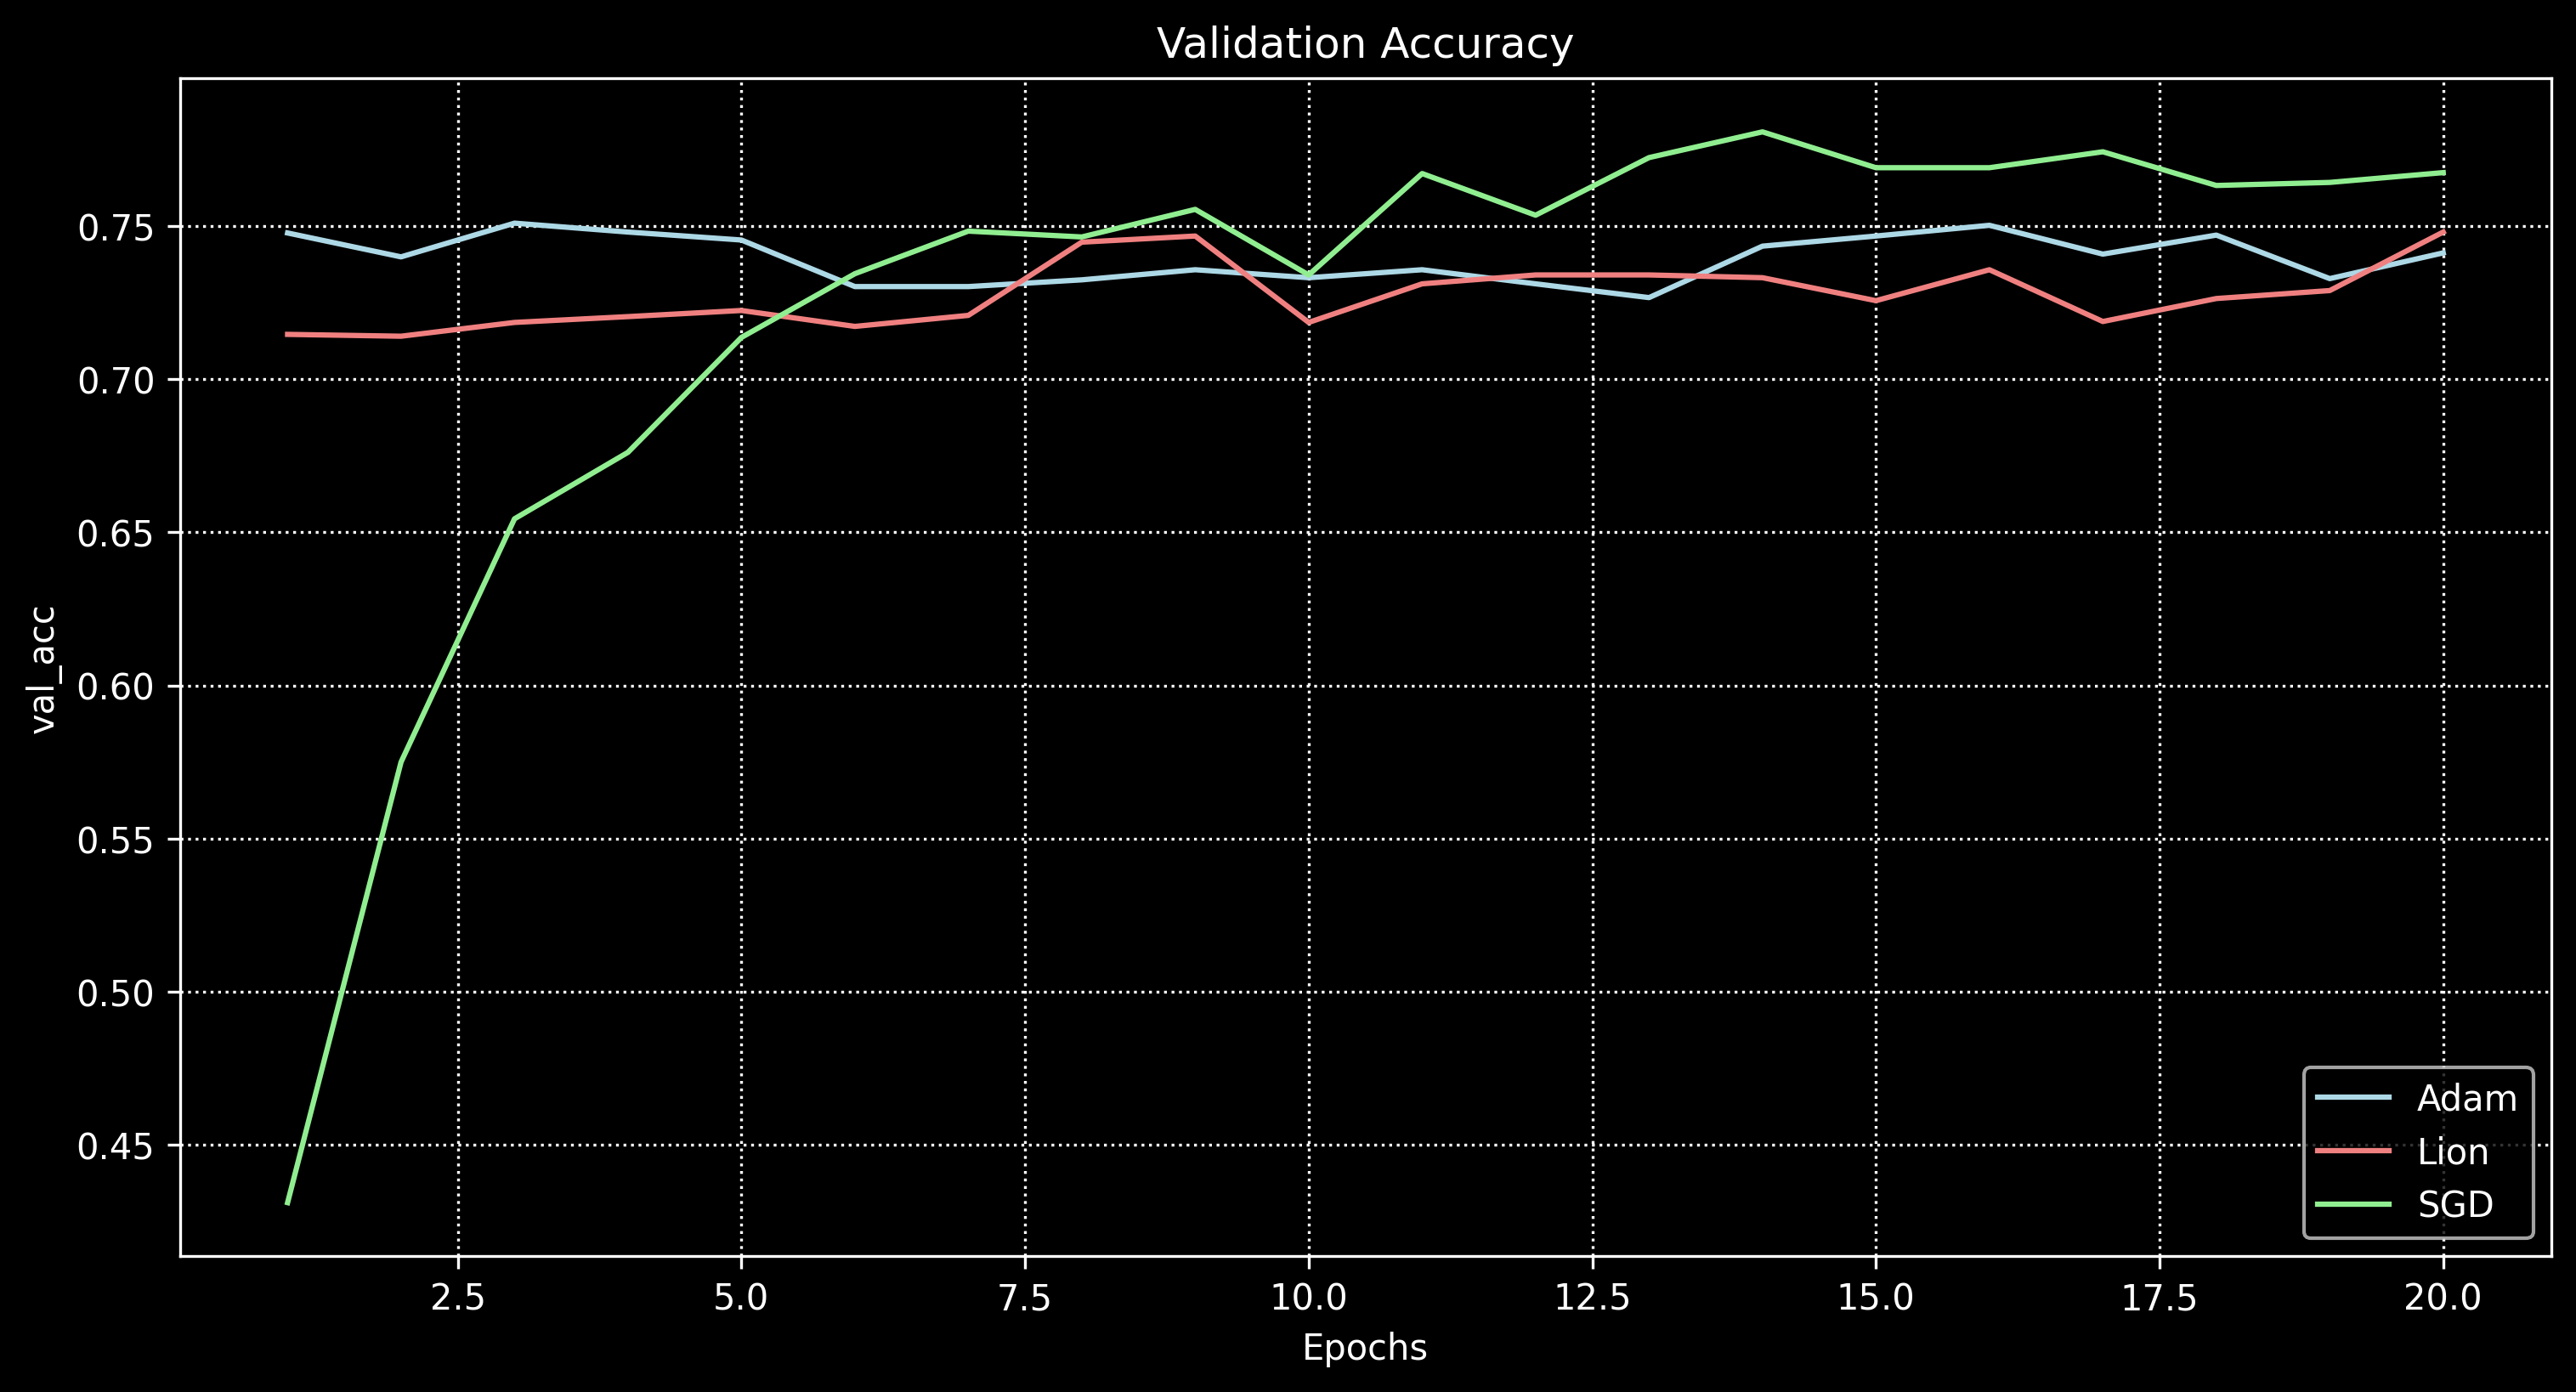

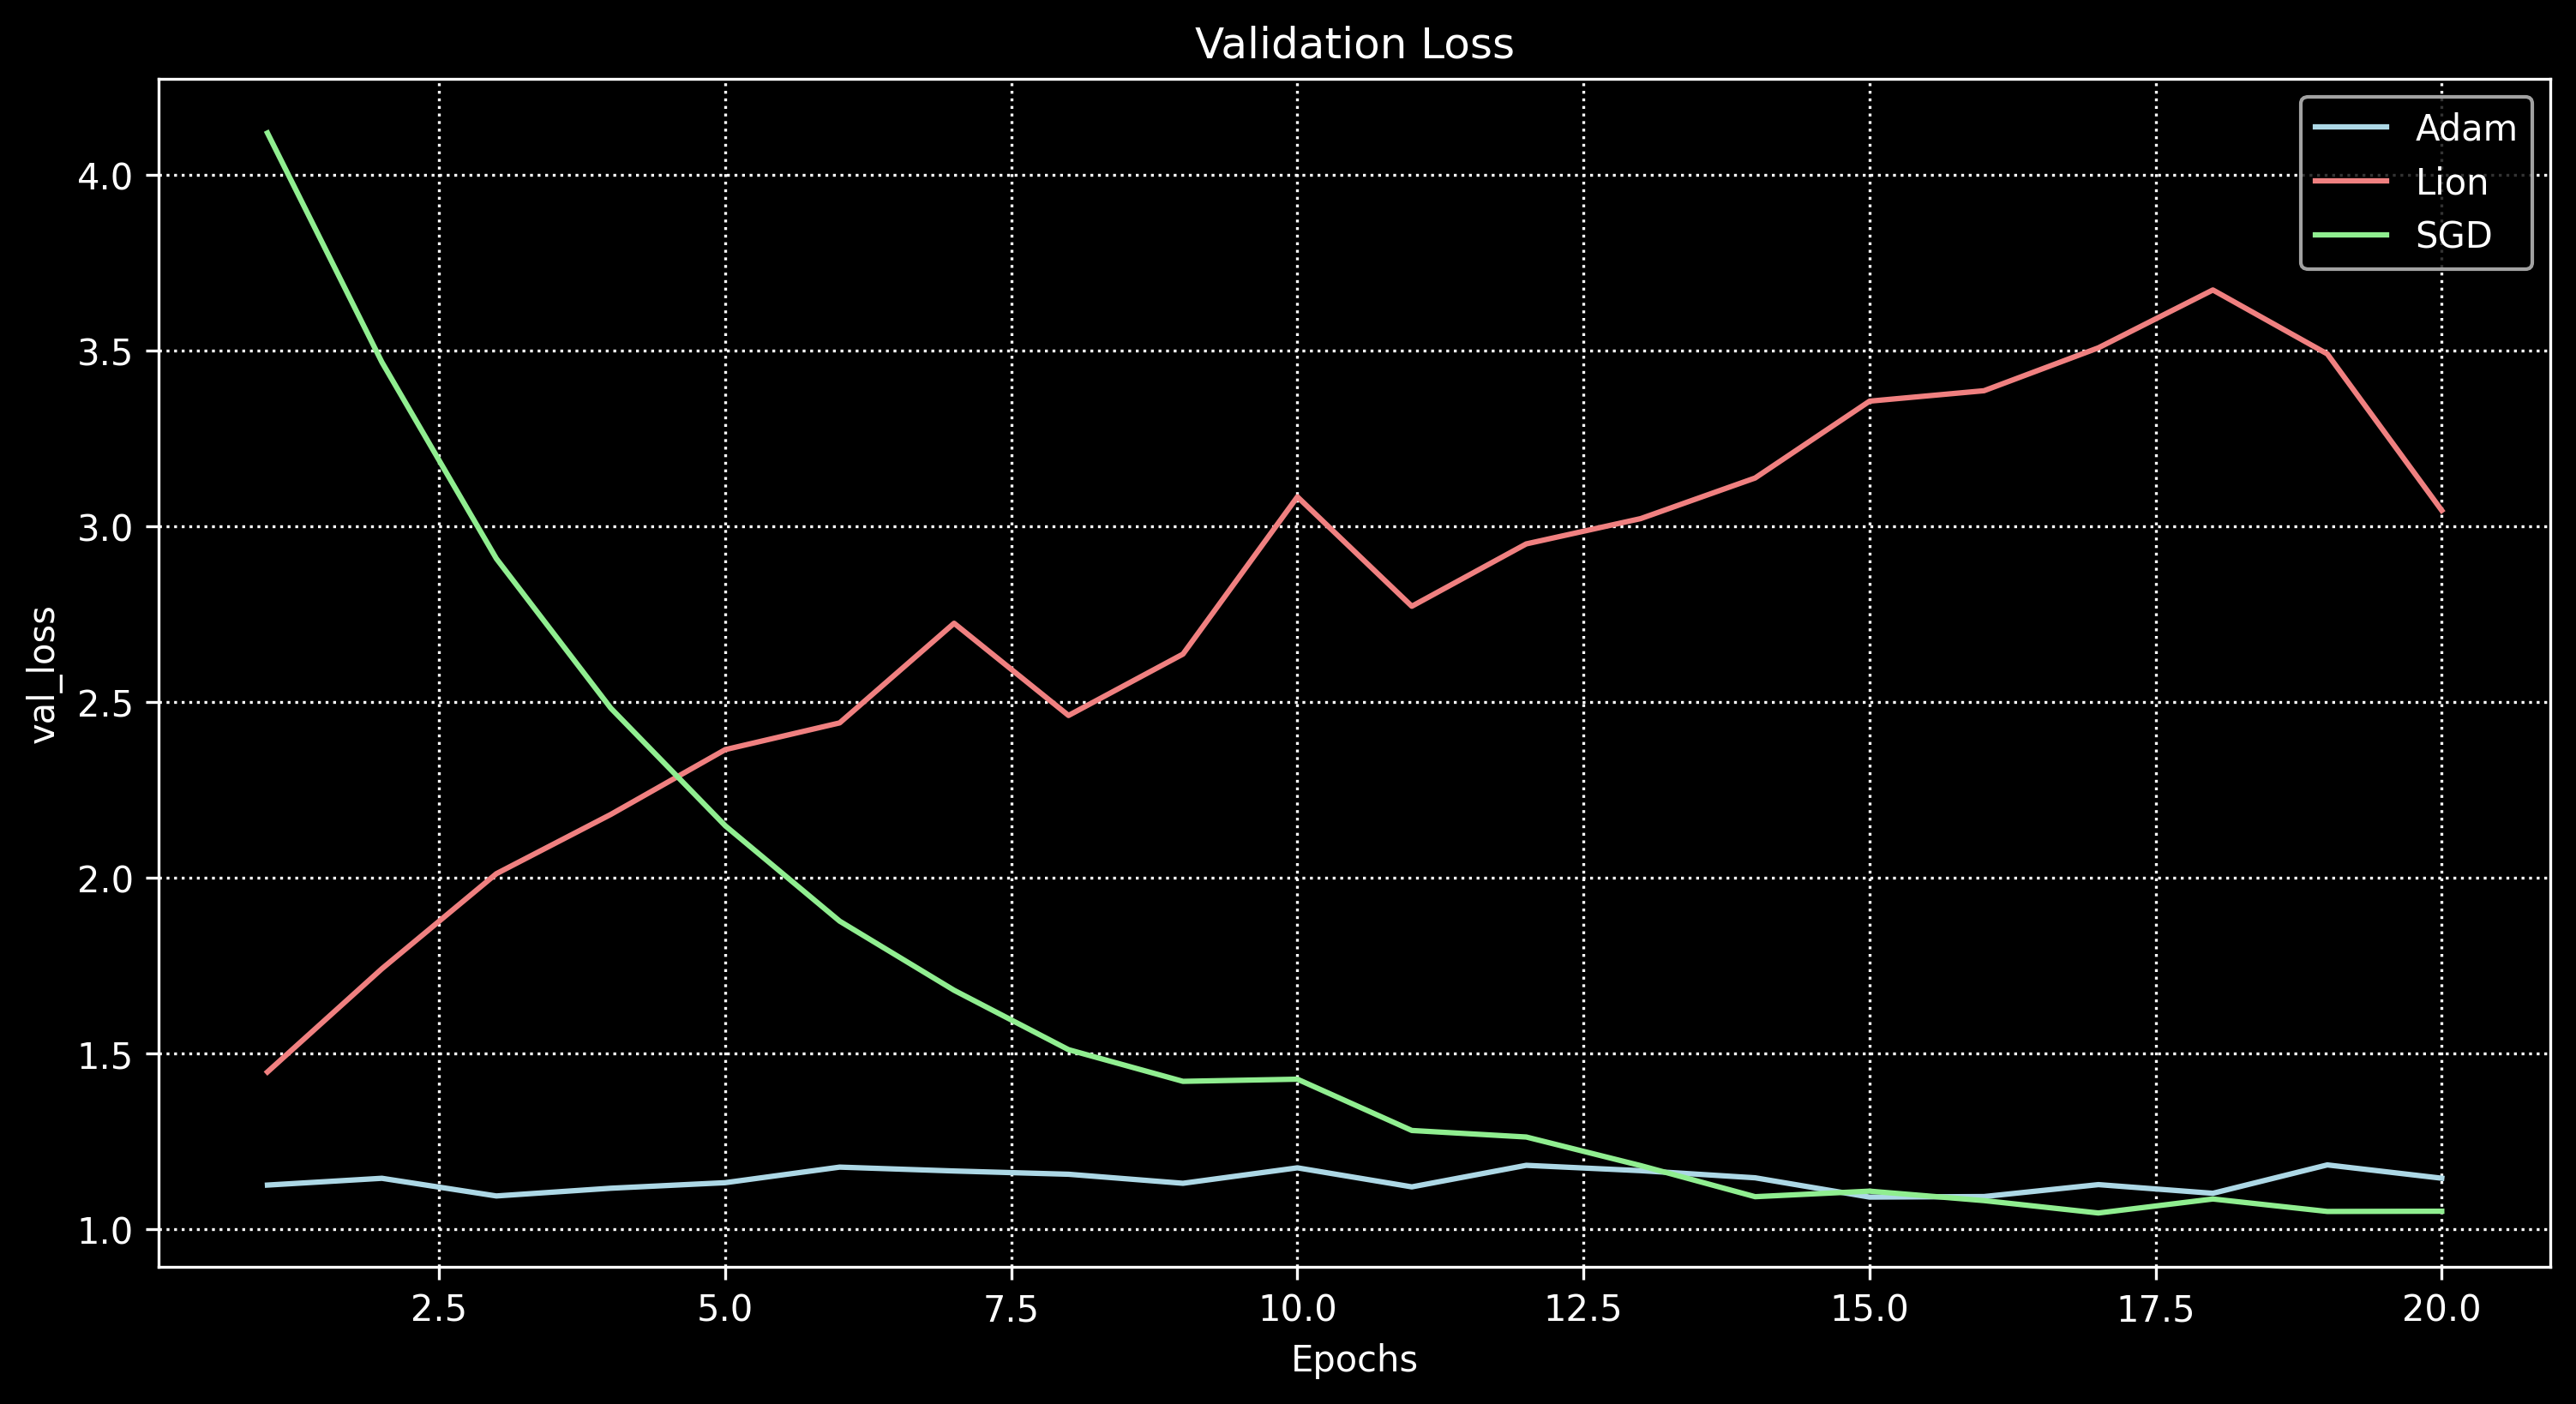

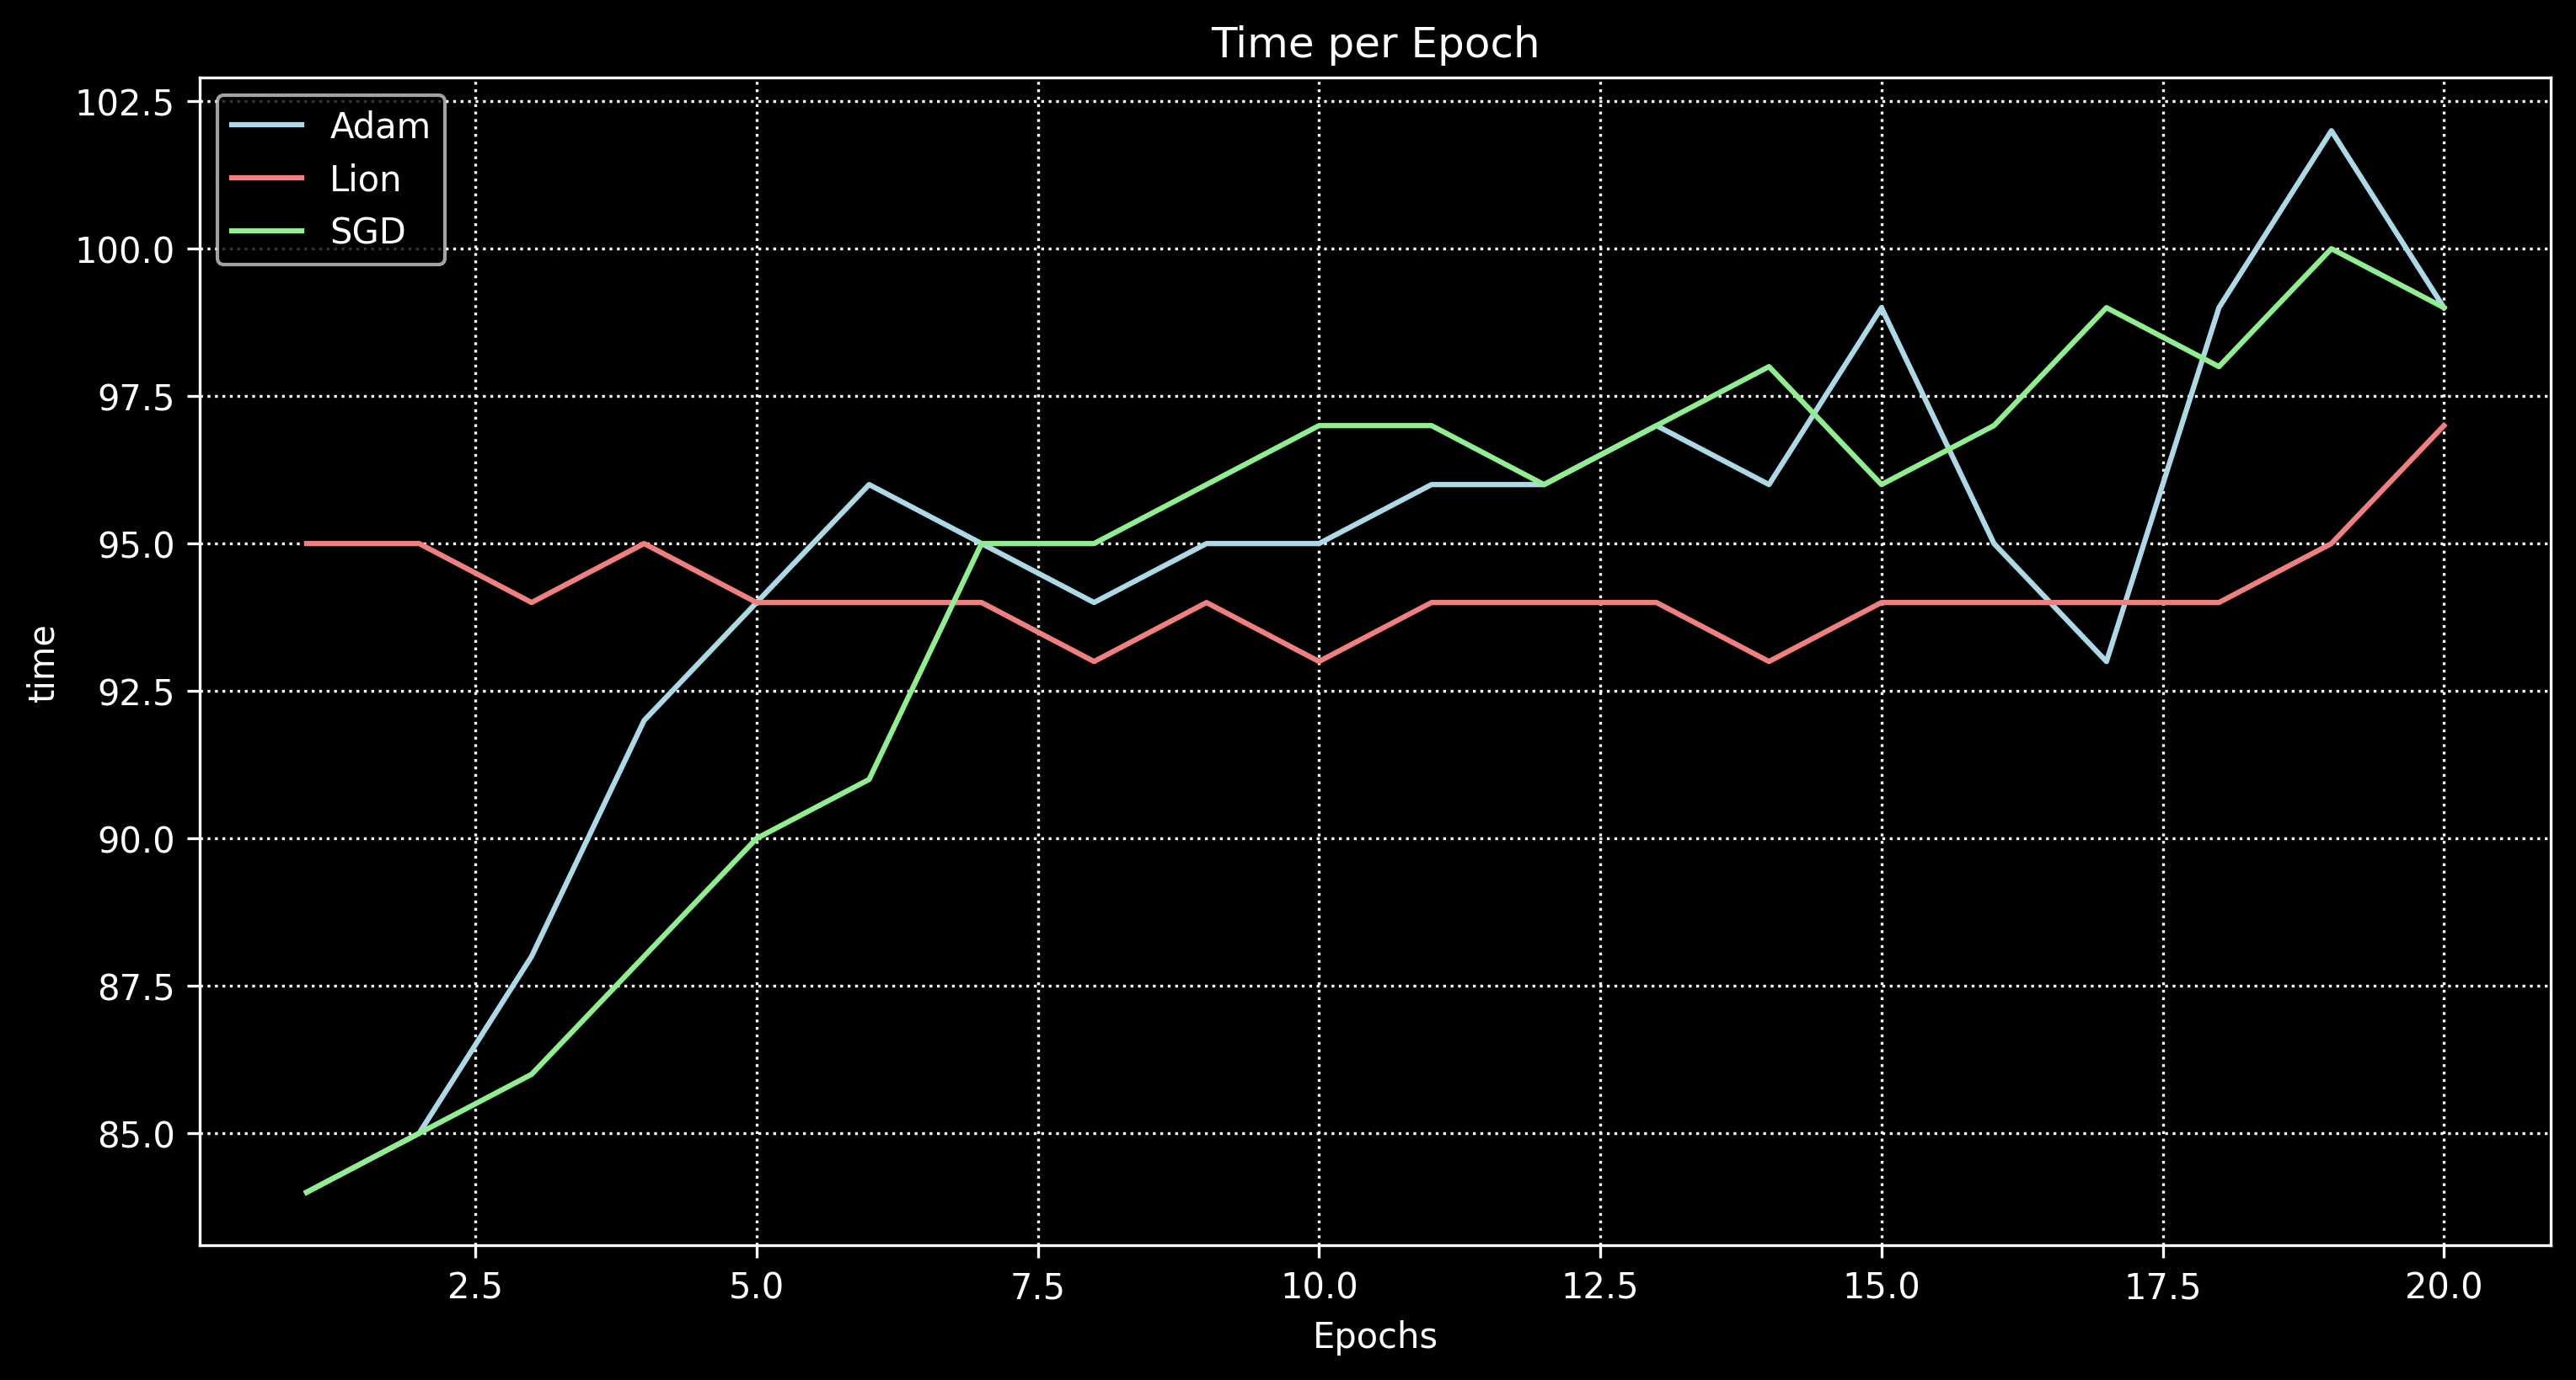

In [196]:
# Set dark theme and font
plt.style.use('dark_background')

# Define a function to plot the metrics with more aesthetically pleasing colors
def plot_metrics_pretty(df1, df2, df3, metric, title):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(df1['epoch'], df1[metric], label='Adam', color='lightblue')
    plt.plot(df2['epoch'], df2[metric], label='Lion', color='lightcoral')
    plt.plot(df3['epoch'], df3[metric], label='SGD', color='lightgreen')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, linestyle='dotted')
    plt.show()

# Plot validation accuracy
plot_metrics_pretty(df1, df2, df3, 'val_acc', 'Validation Accuracy')

# Plot validation loss
plot_metrics_pretty(df1, df2, df3, 'val_loss', 'Validation Loss')

# Plot time
plot_metrics_pretty(df1, df2, df3, 'time', 'Time per Epoch')

In [198]:
# Calculate the mean of time, validation loss, and validation accuracy for each model
model_means = {
    'adam': [df1['time'].mean(), df1['val_loss'].mean(), df1['val_acc'].mean()],
    'lion': [df2['time'].mean(), df2['val_loss'].mean(), df2['val_acc'].mean()],
    'sgd': [df3['time'].mean(), df3['val_loss'].mean(), df3['val_acc'].mean()]
}

# Convert the dictionary to a DataFrame
model_means_df = pd.DataFrame(model_means, index=['Time', 'Validation Loss', 'Validation Accuracy'])

# Transpose the DataFrame to have the models as rows and metrics as columns
model_means_df = model_means_df.transpose()

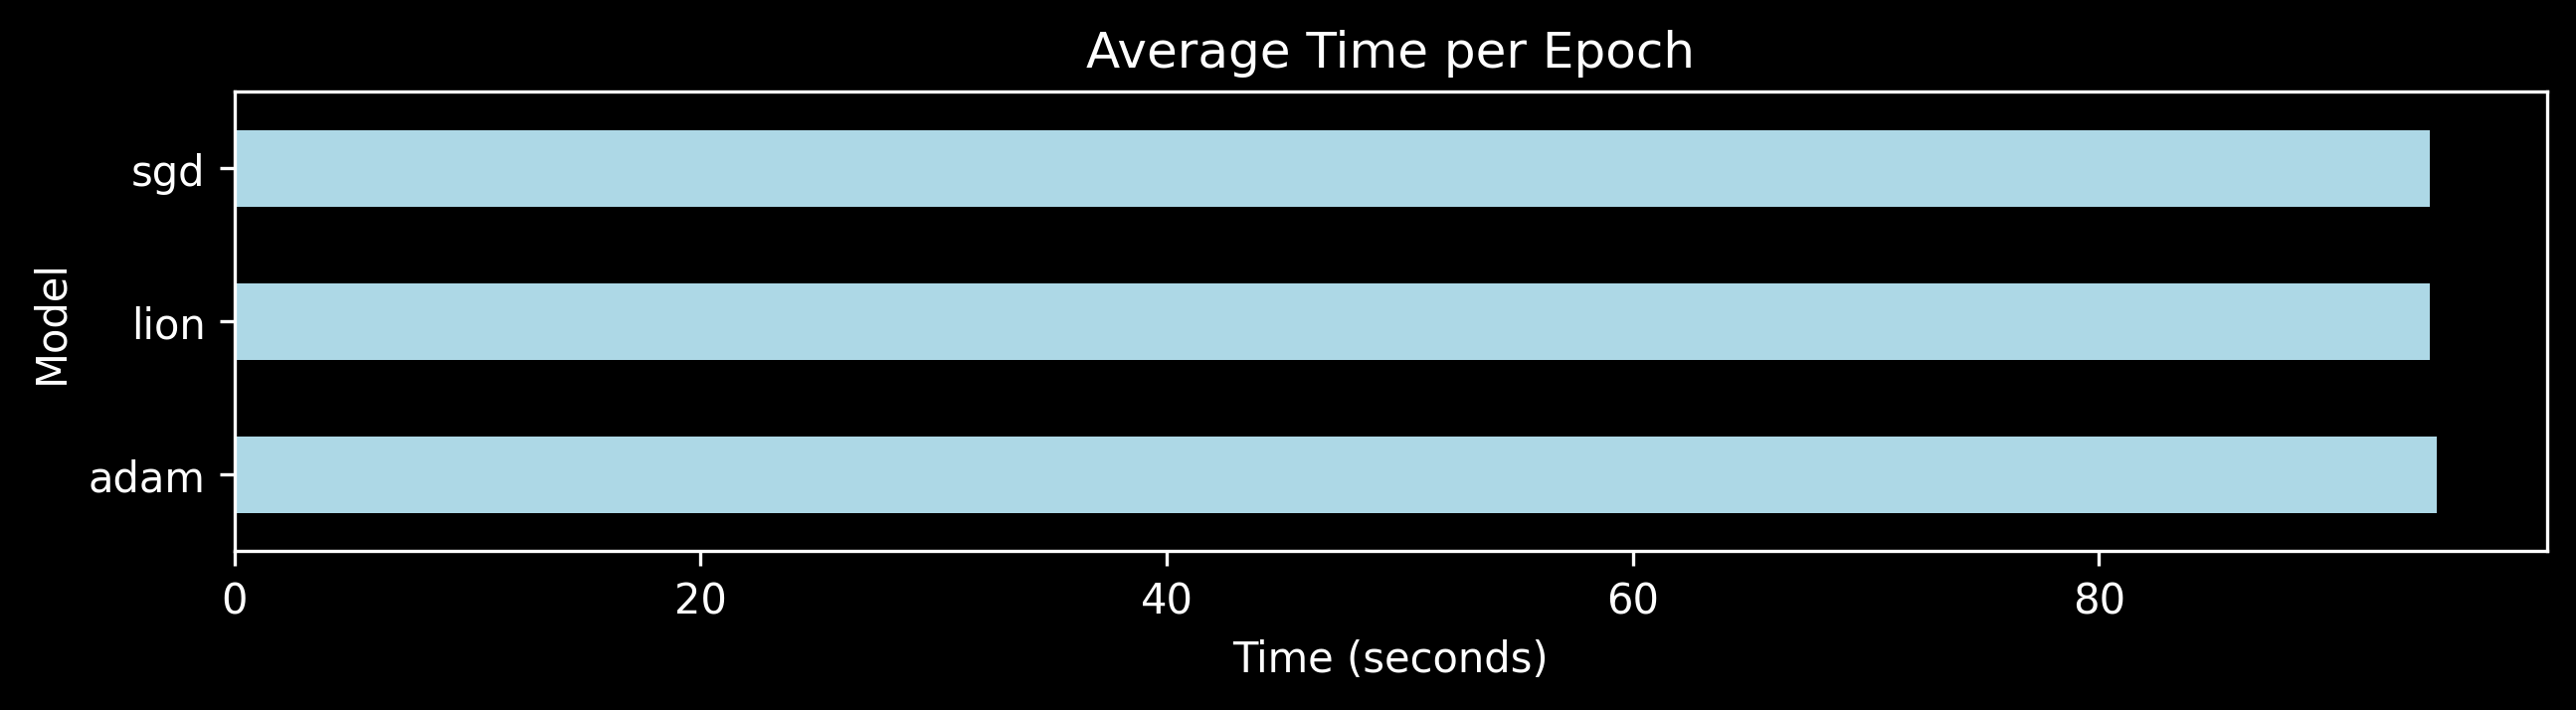

In [220]:
# Split the data into two DataFrames for easier plotting
time_df = model_means_df['Time']
val_df = model_means_df[['Validation Loss', 'Validation Accuracy']]

# Plot time
plt.figure(figsize=(10, 2), dpi=300)
time_df.plot(kind='barh', color='lightblue', width=0.5)
plt.title('Average Time per Epoch')
plt.xlabel('Time (seconds)')
plt.ylabel('Model')
plt.grid(False)
plt.show()

<Figure size 1500x900 with 0 Axes>

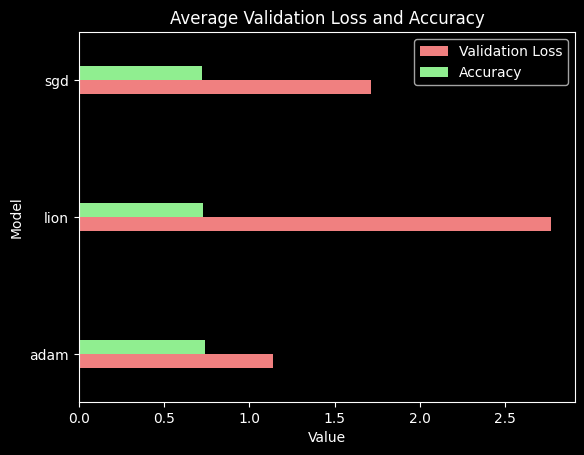

In [235]:
# Plot validation loss and accuracy
plt.figure(figsize=(10, 6), dpi = 150)

val_df.plot(kind='barh', color=['lightcoral', 'lightgreen'], width=0.2)

plt.title('Average Validation Loss and Accuracy')
plt.xlabel('Value')
plt.ylabel('Model')
plt.legend(loc='best', labels=['Validation Loss', 'Accuracy'])
plt.grid(False)

plt.show()

In [3]:
# Load the data from the CSV files
vit_adam_data = pd.read_csv('ViT_adam_epoch.csv')
vit_sgd_data = pd.read_csv('ViT_SGD_epoch.csv')

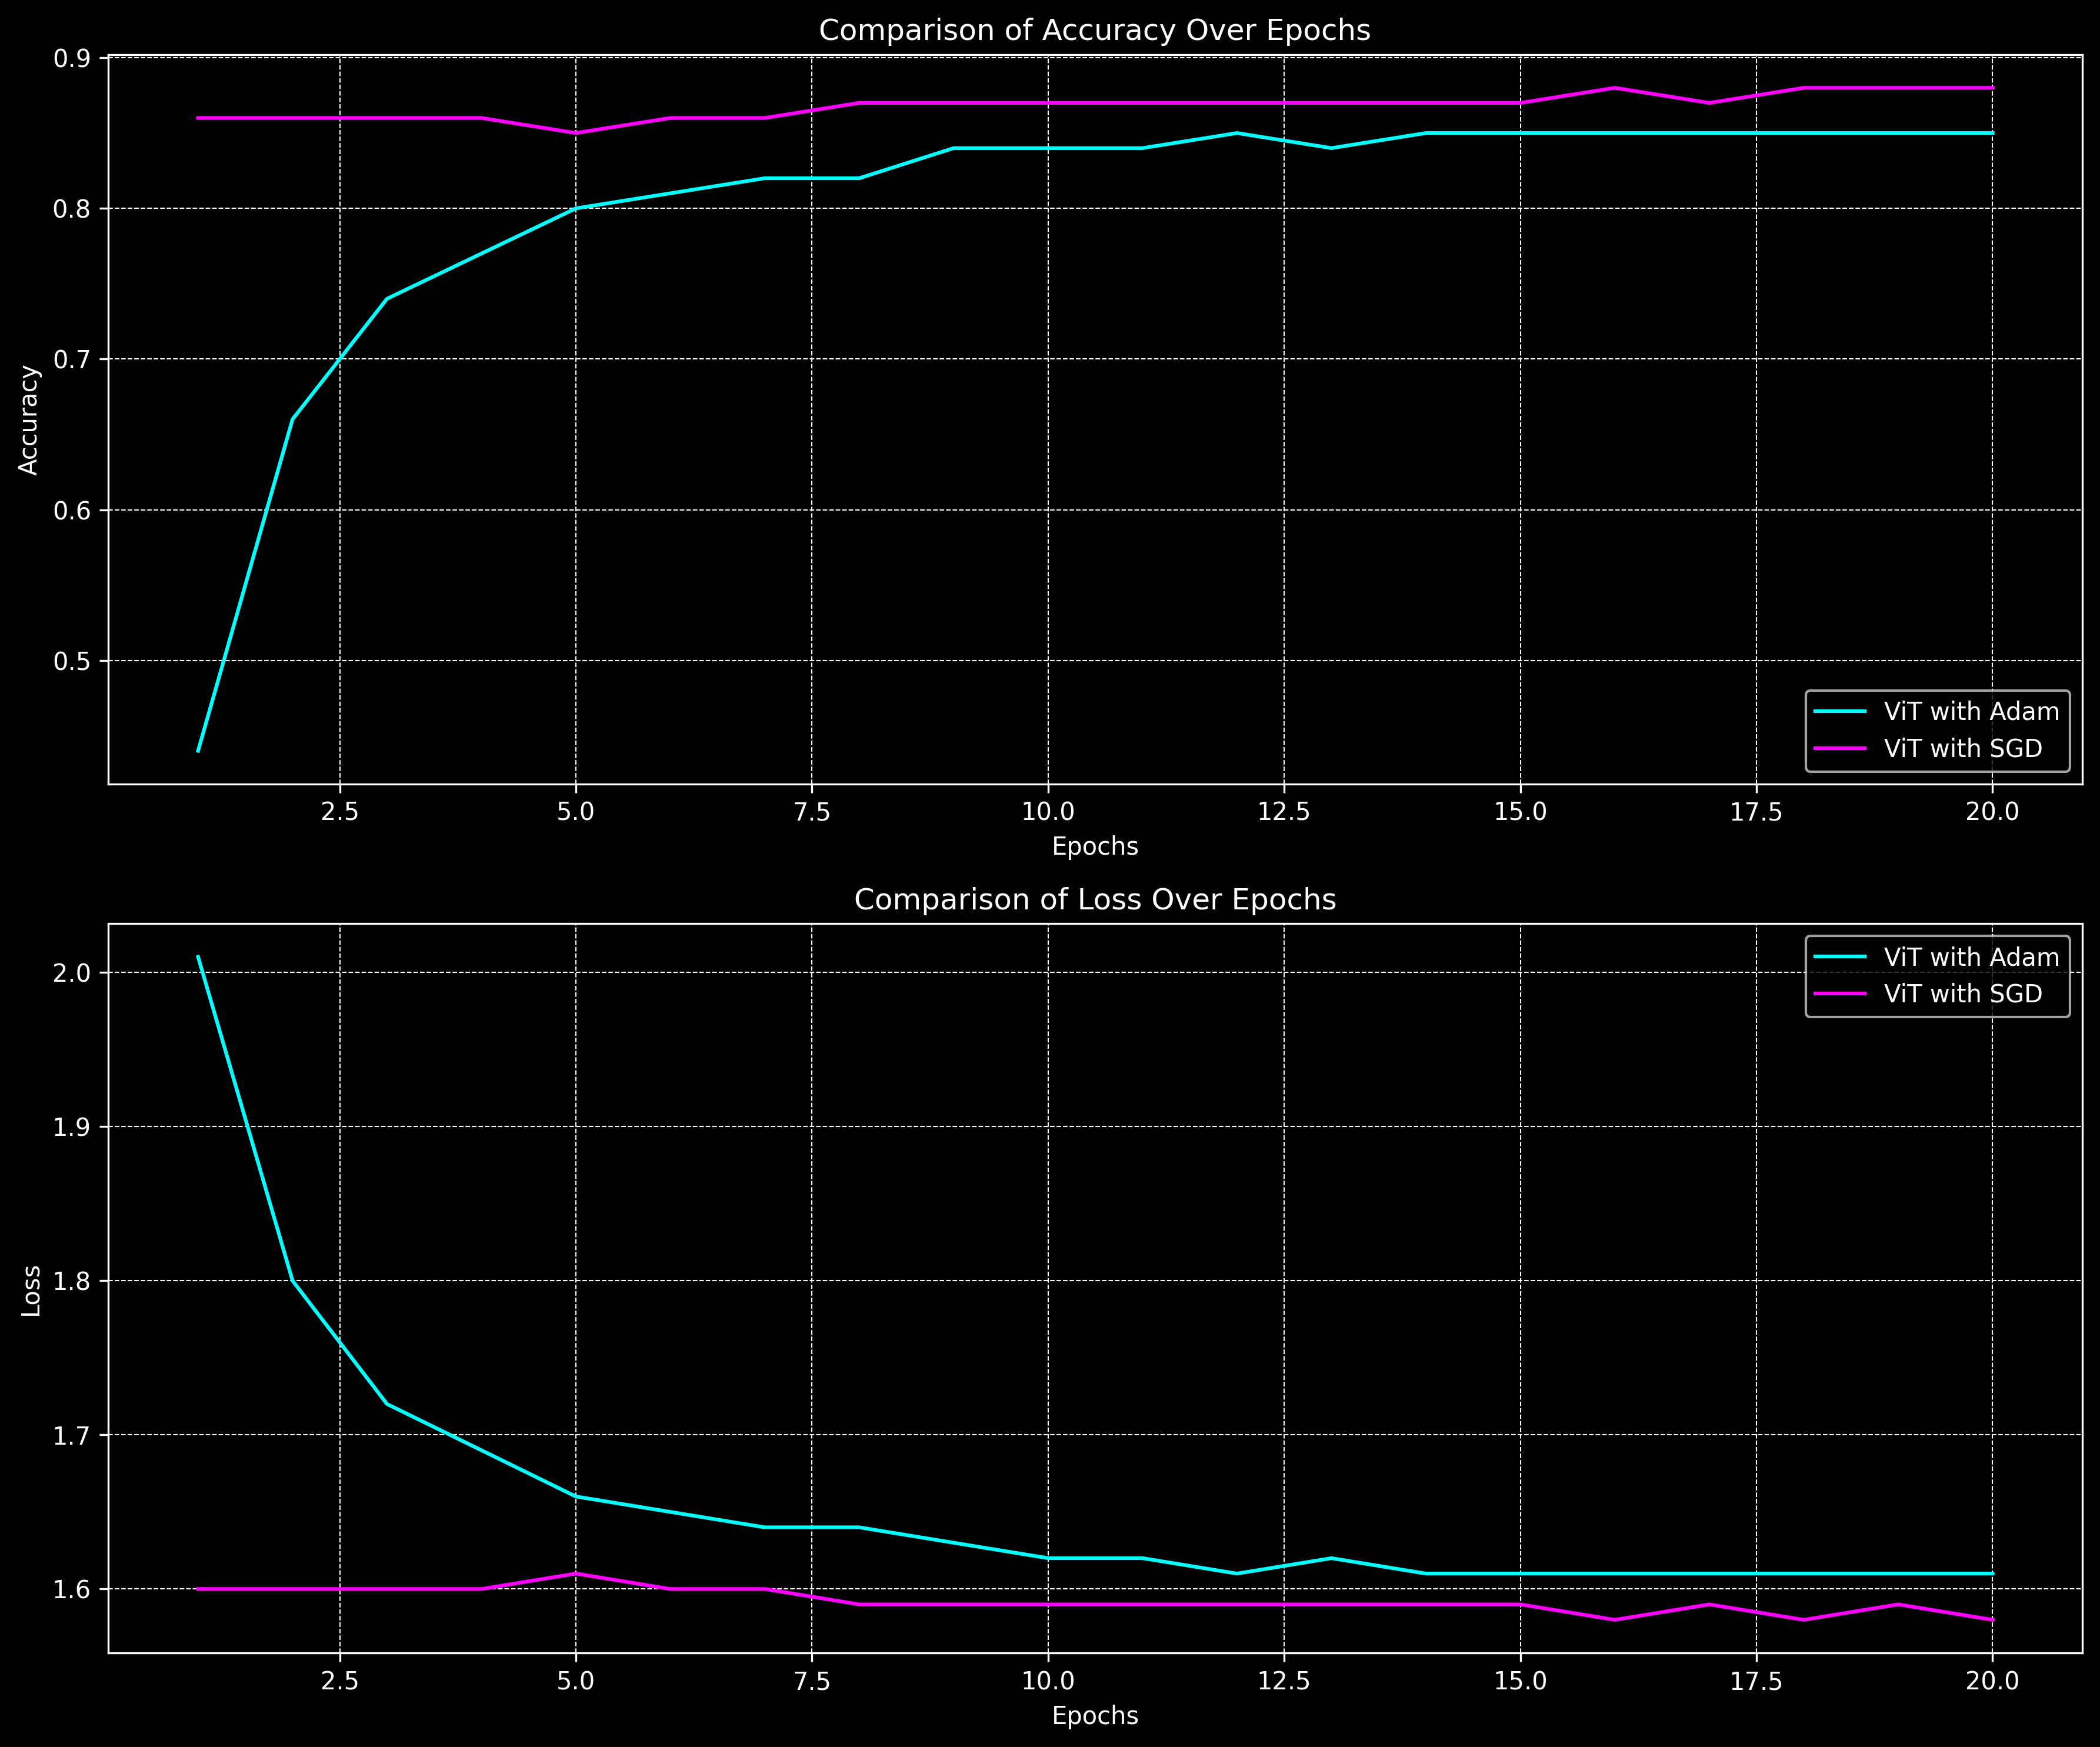

In [6]:
# Set the dark background style for the plots
plt.style.use('dark_background')

# Set up the figure and axes for the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=300)

# Plot the accuracy for both optimizers
ax1.plot(vit_adam_data['Epoch'], vit_adam_data['Accuracy'], label='ViT with Adam', color='cyan')
ax1.plot(vit_sgd_data['Epoch'], vit_sgd_data['Accuracy'], label='ViT with SGD', color='magenta')
ax1.set_title('Comparison of Accuracy Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot the loss for both optimizers
ax2.plot(vit_adam_data['Epoch'], vit_adam_data['Loss'], label='ViT with Adam', color='cyan')
ax2.plot(vit_sgd_data['Epoch'], vit_sgd_data['Loss'], label='ViT with SGD', color='magenta')
ax2.set_title('Comparison of Loss Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

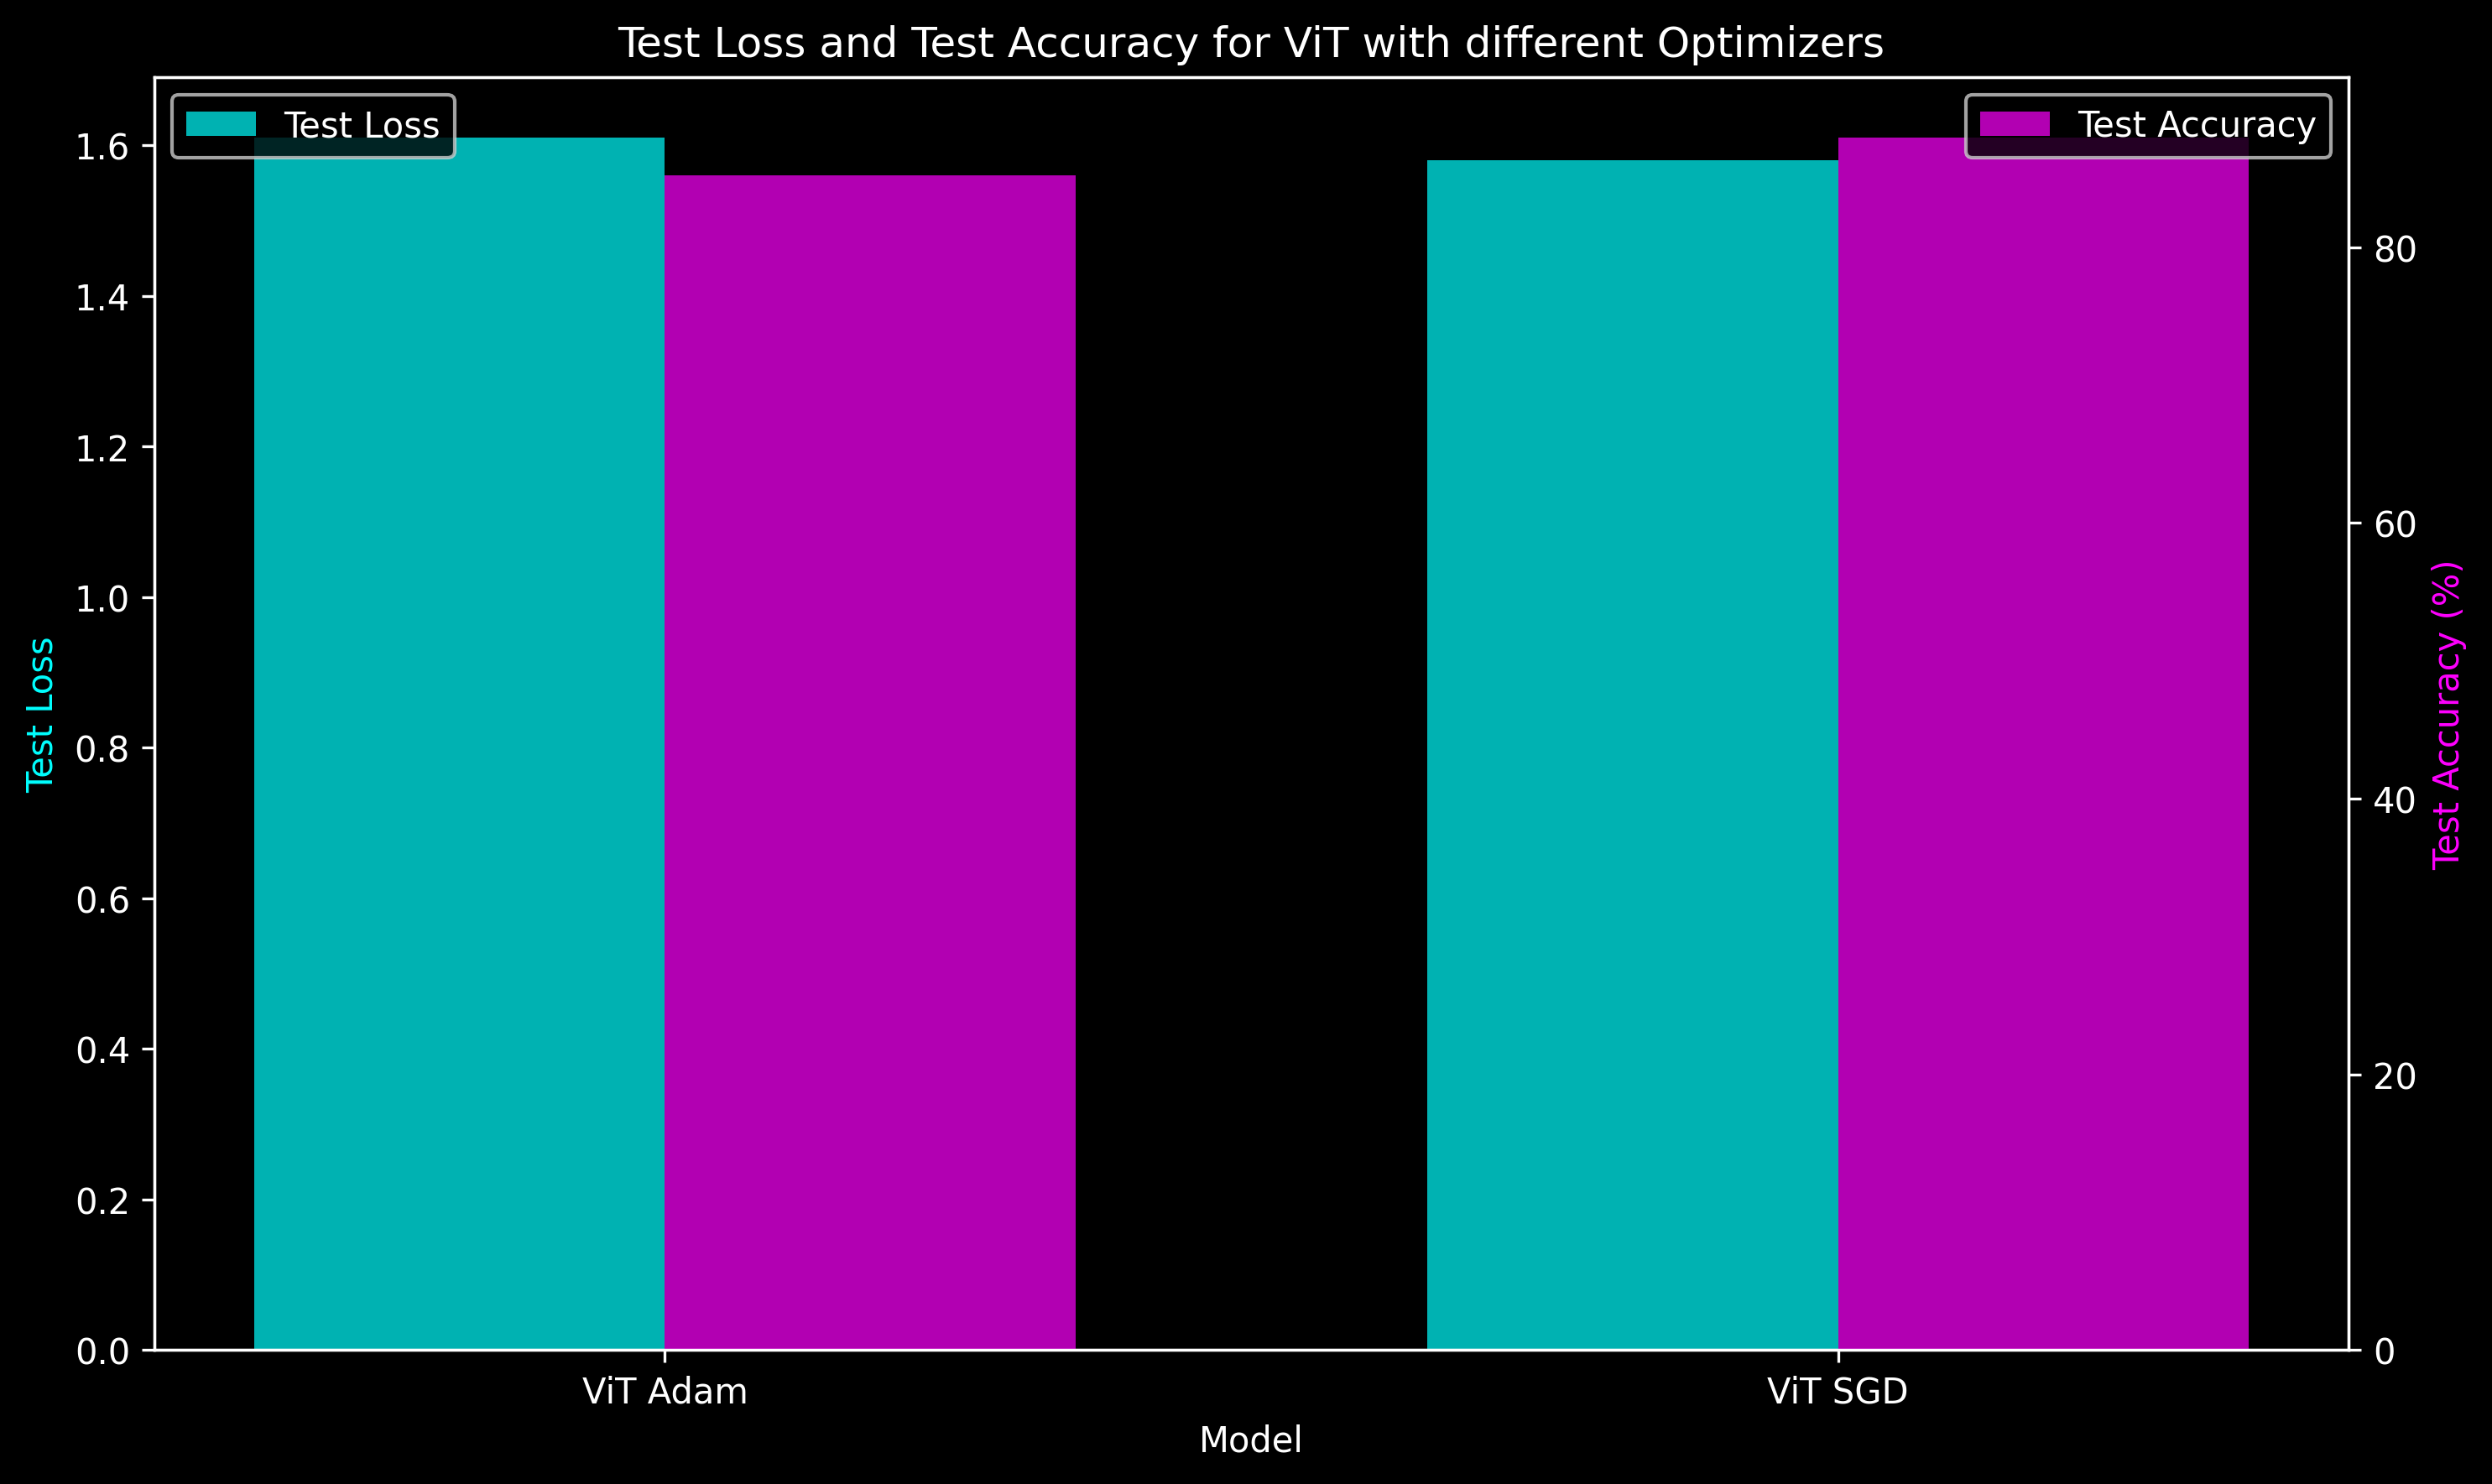

In [11]:
# Data to be visualized
models = ["ViT Adam", "ViT SGD"]
test_loss = [1.61, 1.58]
test_accuracy = [85.22, 87.95]

# Setting the bar width and index for bar positions
bar_width = 0.35
index = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(10,6), dpi = 300)

# Set background color to black
fig.patch.set_facecolor('black')
ax1.set_facecolor('black')

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plotting data
rects1 = ax1.bar(index, test_loss, bar_width, label='Test Loss', color='cyan', alpha=0.7)
rects2 = ax2.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy', color='magenta', alpha=0.7)

# Setting the title and x-axis label
plt.title('Test Loss and Test Accuracy for ViT with different Optimizers')
ax1.set_xlabel('Model')
ax1.set_ylabel('Test Loss', color='cyan')
ax2.set_ylabel('Test Accuracy (%)', color='magenta')
plt.xticks(index + bar_width/2, models)  # Positioning the model names in the center

# Adjusting grid and tick colors
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='y', colors='white')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

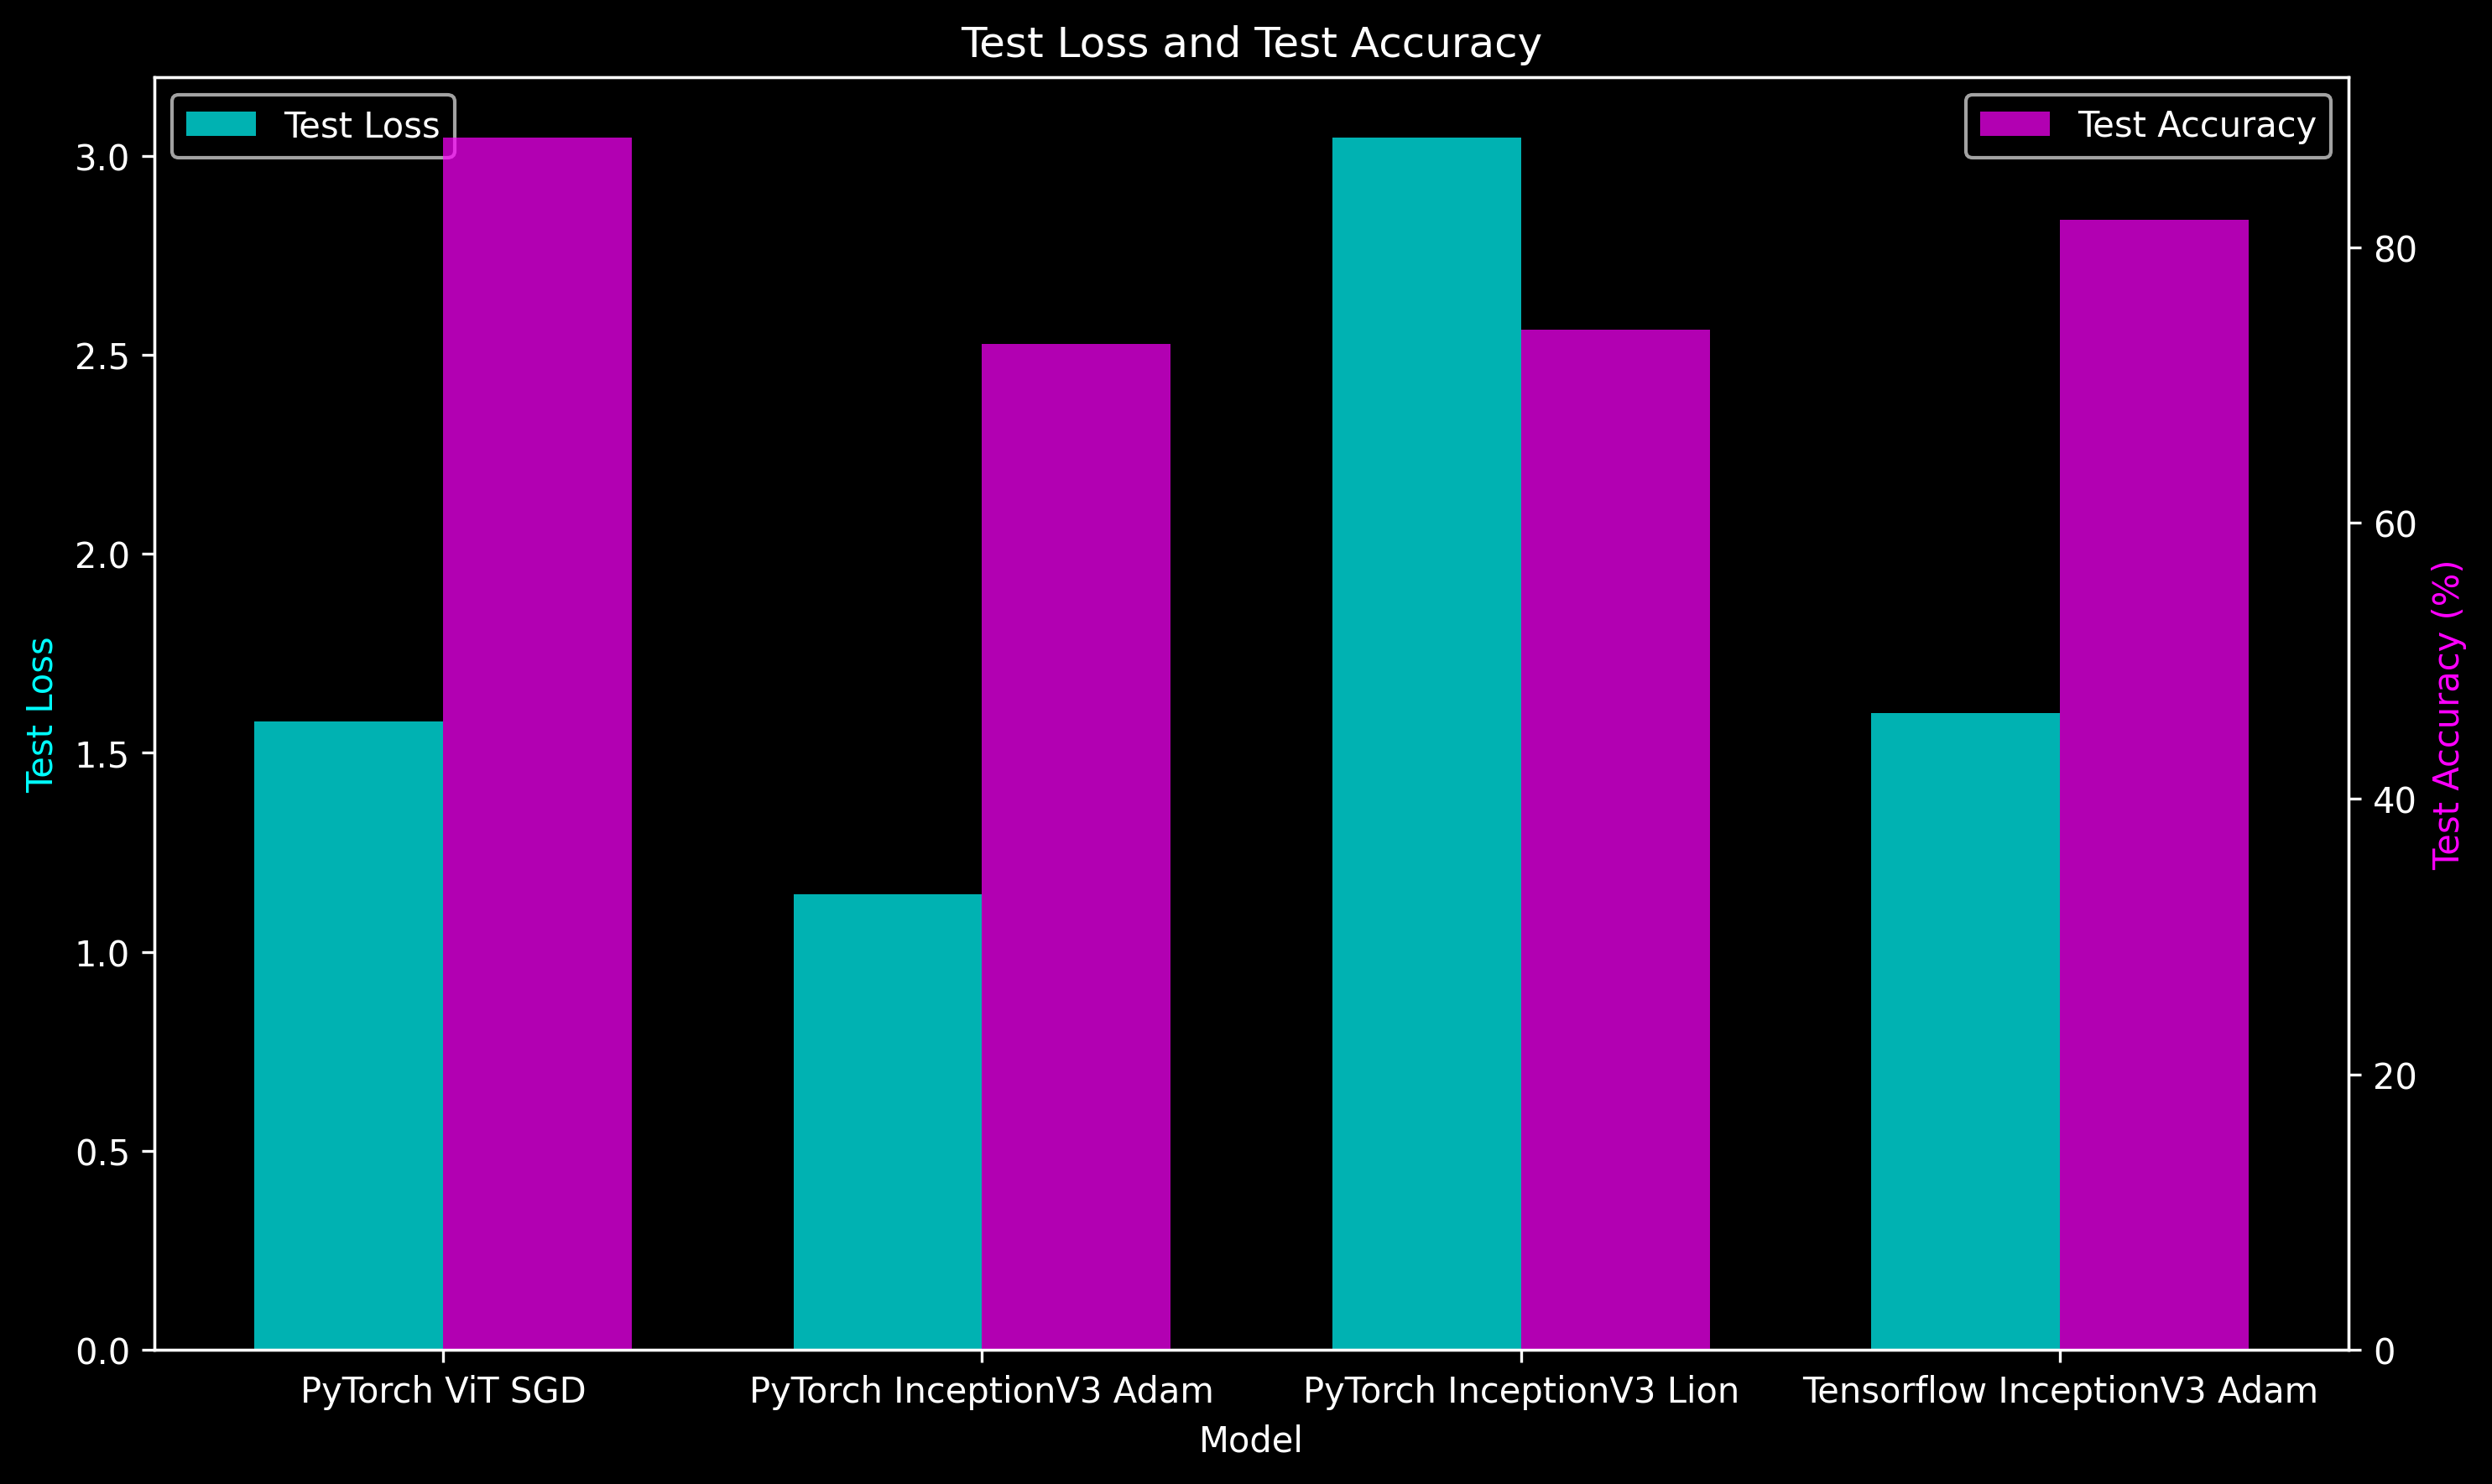

In [14]:
# Data to be visualized
models = ["PyTorch ViT SGD", "PyTorch InceptionV3 Adam", "PyTorch InceptionV3 Lion", "Tensorflow InceptionV3 Adam"]
test_loss = [1.58, 1.1446, 3.0454, 1.60]
test_accuracy = [87.95, 73.00, 74.00, 82.00]

# Setting the bar width and index for bar positions
bar_width = 0.35
index = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(10,6), dpi = 300)

# Set background color to black
fig.patch.set_facecolor('black')
ax1.set_facecolor('black')

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plotting data
rects1 = ax1.bar(index, test_loss, bar_width, label='Test Loss', color='cyan', alpha=0.7)
rects2 = ax2.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy', color='magenta', alpha=0.7)

# Setting the title and x-axis label
plt.title('Test Loss and Test Accuracy')
ax1.set_xlabel('Model')
ax1.set_ylabel('Test Loss', color='cyan')
ax2.set_ylabel('Test Accuracy (%)', color='magenta')
plt.xticks(index + bar_width/2, models)  # Positioning the model names in the center

# Adjusting grid and tick colors
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='y', colors='white')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

ViT à su montrer une précision supérieure de 5% par rapport au modèle créé précédemment sur Tensorflow pour le projet de classification d’images de chiens.
En revanche Lion n’a pas su montrer de meilleure performances que Adam ou SGD.